Connected to Python 3.11.4

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize
import scipy.optimize as optim
from binance.client import Client
from datetime import *
from datetime import time, date, timedelta, datetime
from sympy.utilities.lambdify import lambdify
from sympy import symbols,pi,exp,log,summation,diff,simplify,solve,nsolve,factorial,gamma, sqrt
from itertools import combinations
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller
from heapq import heapify, heappush, heappop 
import warnings
import sys
warnings.filterwarnings("ignore", category=RuntimeWarning)
sys.setrecursionlimit(1000)

In [18]:
api_key = ''
api_secret = ''

client = Client(api_key, api_secret)
"""
crpto = {'BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'XRPUSDT', 'DAIUSDT', 
        'USDCUSDT', 'SOLUSDT', 'TRXUSDT', 'ADAUSDT', 'MATICUSDT', 
        'DOGEUSDT', 'LINKUSDT', 'WBTCUSDT', 'DOTUSDT', 'LTCUSDT', 
        'BCHUSDT', 'SHIBUSDT', 'AVAXUSDT', 'TUSDUSDT', 'XLMUSDT', 
        'XMRUSDT', 'ATOMUSDT', 'UNIUSDT', 'ETCUSDT', 'HBARUSDT', 
        'FILUSDT', 'ICPUSDT', 'APTUSDT', 'LDOUSDT', 'MKRUSDT', 
        'WBETHUSDT', 'VETUSDT', 'QNTUSDT', 'OPUSDT', 'NEARUSDT', 
        'AAVEUSDT', 'INJUSDT', 'ARBUSDT', 'GRTUSDT', 'RNDRUSDT', 
        'STXUSDT', 'RUNEUSDT', 'ALGOUSDT', 'IMXUSDT', 'EGLDUSDT', 
        'AXSUSDT', 'XTZUSDT', 'EOSUSDT', 'SANDUSDT', 'THETAUSDT'}
"""
crpto = {'BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'XRPUSDT', 'DAIUSDT', 
        'USDCUSDT', 'SOLUSDT', 'TRXUSDT', 'ADAUSDT', 'MATICUSDT', 
        'DOGEUSDT', 'LINKUSDT', 'WBTCUSDT', 'DOTUSDT', 'LTCUSDT', 
        'BCHUSDT', 'SHIBUSDT', 'AVAXUSDT'            , 'XLMUSDT', 
        'XMRUSDT', 'ATOMUSDT', 'UNIUSDT', 'ETCUSDT', 'HBARUSDT', 
        'FILUSDT', 'ICPUSDT', 'APTUSDT', 'LDOUSDT', 'MKRUSDT', 
        'WBETHUSDT', 'VETUSDT', 'QNTUSDT', 'OPUSDT', 'NEARUSDT', 
        'AAVEUSDT', 'INJUSDT', 'ARBUSDT', 'GRTUSDT', 'RNDRUSDT', 
        'STXUSDT', 'RUNEUSDT', 'ALGOUSDT', 'IMXUSDT', 'EGLDUSDT', 
        'AXSUSDT', 'XTZUSDT', 'EOSUSDT', 'SANDUSDT', 'THETAUSDT'}

d = dict()
for name in crpto:
#  klines = client.get_historical_klines(name, Client.KLINE_INTERVAL_1HOUR, '1 Jan, 2015')
    klines = client.get_historical_klines(name, Client.KLINE_INTERVAL_1DAY, '1 Jan, 2015')

    df = pd.DataFrame(klines)
    df.columns = ['Open_time','open','high','low','close','volume','Close_time', 'Quote asset volume', 'number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore']
    df = df.drop_duplicates(subset=['Open_time'], keep=False)
    df = df.astype(float)

    df['Open_time'] = pd.to_datetime(df['Open_time'], unit='ms')
    df = df.drop(columns=['Close_time', 'Quote asset volume', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'])
    df.set_index('Open_time', inplace=True)

    d[name] = df

In [19]:
for name in d:
    d[name]['logPrice'] = np.log(d[name]['close'])

for df in d.values():
    df['return'] = (df['close'] - df['open']) / df['open']

In [20]:
startVery = datetime(2019, 1, 1, 0)
endVery = datetime(2023, 12, 31, 23)
trainingLen = timedelta(days=365)
testingLen = timedelta(days=183)
intervalNum = 14
movingLen = (endVery - (startVery + trainingLen + testingLen)) / intervalNum

print(movingLen)

91 days, 6:47:08.571429


In [21]:
names = list(d.keys())
allPairs = list(combinations(names , 2))
pairs = list(combinations(names , 2))
selected = dict()
selectedFinalName = []

In [22]:
for x in range(intervalNum):
    print('window:', x)
    start = startVery + movingLen * x
    end = start + trainingLen
    print(start, end)

    startTesting = startVery + trainingLen + movingLen * x
    endTesting = startTesting + testingLen
    selected = dict()
    for pair in allPairs:
        name_P = pair[0]
        name_Q = pair[1]

        if start < max(d[name_P].index[0], d[name_Q].index[0]):
            continue

        P = d[name_P]['close'].loc[start : end]
        Q = d[name_Q]['close'].loc[start : end]

        Ptest = d[name_P]['logPrice'].loc[startTesting : endTesting]
        Qtest = d[name_Q]['logPrice'].loc[startTesting : endTesting]

        if len(P) != len(Q):
            continue
        if len(Ptest) != len(Qtest):        
            continue
        if P.empty or Q.empty:
            continue
        
        Y = np.log(P) - np.log(P.iloc[0])
        X = np.log(Q) - np.log(Q.iloc[0])
        res = sm.OLS(Y, X).fit()
        beta = res.params[0]
        spread = Y - beta * X
        
        """
        ADF
        H0: exits unit root (is I(1)) not stationary
        H1: no unit root (not I(1))
        """
        [adf, pADF, lag, nobs, crit, icbest] = adfuller(spread)
        if pADF <= 0.05:
            [t, p, crit] = ts.coint(P, Q) # crit = {1%, 5%, 10%}
            if p <= 0.05:
                selected[(name_P, name_Q)] = (t, p)
    
    # find the most fitted pair

    heap = []  #((t, p), (P, Q))
    param = dict()
    heapify(heap) 
    for tup1, tup2 in selected.items():
        heappush(heap, (tup2, tup1))

    for _ in range(1):
        element = heappop(heap)
        print(element[0])
        selectedFinal = element[1]

    print(selectedFinal)
    selectedFinalName.append(selectedFinal)

window: 0
2019-01-01 00:00:00 2020-01-01 00:00:00
(-4.357272867161429, 0.002081243157414501)
('USDCUSDT', 'BTCUSDT')
window: 1
2019-04-02 06:47:08.571429 2020-04-01 06:47:08.571429
(-5.1819550129871566, 7.516535744839557e-05)
('USDCUSDT', 'VETUSDT')
window: 2
2019-07-02 13:34:17.142858 2020-07-01 13:34:17.142858
(-5.20808277470918, 6.70125969043162e-05)
('USDCUSDT', 'ATOMUSDT')
window: 3
2019-10-01 20:21:25.714287 2020-09-30 20:21:25.714287
(-4.859480798109736, 0.00029596241917584473)
('MATICUSDT', 'DOGEUSDT')
window: 4
2020-01-01 03:08:34.285716 2020-12-31 03:08:34.285716
(-4.190672269087157, 0.0037683425678807433)
('XLMUSDT', 'STXUSDT')
window: 5
2020-04-01 09:55:42.857145 2021-04-01 09:55:42.857145
(-5.511831527654151, 1.6964930592552377e-05)
('ETCUSDT', 'DOGEUSDT')
window: 6
2020-07-01 16:42:51.428574 2021-07-01 16:42:51.428574
(-5.731709562293809, 6.014970367600007e-06)
('USDCUSDT', 'BCHUSDT')
window: 7
2020-09-30 23:30:00.000003 2021-09-30 23:30:00.000003
(-5.301952319137811, 4.4

In [23]:
paramFirst = []
paramSecond = []
for i in range(intervalNum):
    print('window:', i)
    name_P = selectedFinalName[i][0]
    name_Q = selectedFinalName[i][1]

    """
    startTesting = startVery + trainingLen + movingLen * i
    endTesting = startTesting + testingLen

    logP = d[name_P]['logPrice'].loc[startTesting : endTesting]
    logQ = d[name_Q]['logPrice'].loc[startTesting : endTesting]
    """
    start = startVery + movingLen * i
    end = start + trainingLen
    print(start, end)

    logP = d[name_P]['logPrice'].loc[start : end]
    logQ = d[name_Q]['logPrice'].loc[start : end]

    slope, intercept, r_value, p_value, std_err = stats.linregress(logQ, logP)
    print("beta: %f intercept %f" % (slope, intercept))
    print("R-squared: %f" % r_value ** 2)

    X = logP - slope * logQ
    n = len(X)

    """
    define parameters
    """
    mu = X.mean()
    theta = symbols('theta')
    sigma = symbols('sigma')
    n = X.shape[0]
    dt = 1/n
    inf = float('inf')

    """
    OU process params estimate
    """
    llf_1 = 0
    for i in range(1, n-1): 
        llf_1 = llf_1 + log(1 - exp(-2 * theta * dt))

    llf_2 = 0
    for i in range(1, n-1):
        llf_2 = llf_2 + (X[i] - mu - (X[i-1] - mu) * exp(-theta * dt)) / (1 - exp(-2 * theta * dt))

    llf = (-1 * n/2 - 0.5 * llf_1 - (theta/sigma**2) * llf_2)*(-1)

    llf = lambdify((theta, sigma), llf)

    def equation(x):
        theta = x[0]
        sigma = x[1]
        return abs(llf(theta, sigma))

    init = np.array([0.001, 0.01])
    sol = optim.minimize(equation, x0 = init, method = 'Nelder-Mead', options = {"disp": False}) 
    theta = sol.x[0]
    sigma = sol.x[1]
    print(f'mu = {mu}, theta = {theta}, sigma = {sigma}, val = {sigma/((2*theta)**0.5)}')

    """
    Case 1 boundary estimate
    """
    a_1 = symbols('a_1')
    b_1 = 0
    c_1 = 0.002
    max_eq_1 = 0

    for j in range(0, 100):
        max_eq_1 += (a_1-c_1) * (sqrt(2)/2) * (sqrt(2)*a_1)**(2*j)/factorial(2*j) * factorial(j + 0.5)
    max_eq_1_neg = -max_eq_1
    max_eq_1_neg = lambdify(a_1, max_eq_1_neg)

    def equation_1(x):
        a_1 = x[0]
        return abs(max_eq_1_neg(a_1))

    init_1 = 10
    sol_1 = optim.minimize(equation_1, x0 = init_1, method = 'Nelder-Mead')
    a_1 = sol_1.x[0]
    #print(f'a = {a_1}, b = {b_1}, c = {c_1}')

    ## return a_1, b_1, c_1
    tilde_a1_1 = a_1 * sigma / ((2 * theta)**0.5) + mu
    tilde_a1_2 = -a_1 * sigma / ((2 * theta)**0.5) + mu
    tilde_b_1 = b_1 * sigma / ((2 * theta)**0.5) + mu
    tilde_c_1 = c_1 * sigma / ((2 * theta)**0.5)
    # print(f'tilde_a1 = {tilde_a1_1}, tilde_a2 = {tilde_a1_2}, tilde_b = {tilde_b_1}, tilde_c = {tilde_c_1}')
    ## return tilde_a1_1, tilde_a1_2, tilde_b_1, tilde_c_1
    paramFirst.append((tilde_a1_1, tilde_a1_2, tilde_b_1, tilde_c_1))

    """
    Case 2 boundary estimate
    """
    a_2 = symbols('a_2')
    c_2 = 0.002
    max_eq_2 = 0

    for j in range(0, 100):
        max_eq_2 += (a_2 - 0.5*c_2) * (sqrt(2)/2) * (sqrt(2)*a_2)**(2*j)/factorial(2*j) * factorial(j + 0.5)
    max_eq_2_neg = -max_eq_2
    max_eq_2_neg = lambdify(a_2, max_eq_2_neg)

    def equation_2(x):
        a_2 = x[0]
        return abs(max_eq_2_neg(a_2))

    init_2 = 10
    sol_2 = optim.minimize(equation_2, x0 = init_2, method = 'Nelder-Mead')
    a_2 = sol_2.x[0]
    b_2 = -a_2
    #print(f'a = {a_2}, b = {b_2}, c = {c_2}')

    ## return a_2, b_2, c_2
    tilde_a2_1 = a_2 * sigma / ((2 * theta)**0.5) + mu
    tilde_a2_2 = -a_2 * sigma / ((2 * theta)**0.5) + mu
    tilde_b_2 = b_2 * sigma / ((2 * theta)**0.5) + mu
    tilde_c_2 = c_2 * sigma / ((2 * theta)**0.5)
    #print(f'tilde_a1 = {tilde_a2_1}, tilde_a2 = {tilde_a2_2}, tilde_b = {tilde_b_2}, tilde_c = {tilde_c_2}')
    paramSecond.append((tilde_a2_1, tilde_a2_2, tilde_c_2))
    print('\n')

window: 0
2019-01-01 00:00:00 2020-01-01 00:00:00
beta: -0.003473 intercept 0.031482
R-squared: 0.059432
mu = 0.03148241925953124, theta = 1.0483524814353767e-05, sigma = 0.02858891578832229, val = 6.243513050223056


window: 1
2019-04-02 06:47:08.571429 2020-04-01 06:47:08.571429
beta: 0.001297 intercept 0.006799
R-squared: 0.007032
mu = 0.00679902161812188, theta = 5.008140463629552e-05, sigma = 0.018914475332816844, val = 1.8899096848618002


window: 2
2019-07-02 13:34:17.142858 2020-07-01 13:34:17.142858
beta: 0.001726 intercept -0.002324
R-squared: 0.092872
mu = -0.0023237481714928256, theta = 0.00017136709616861183, sigma = 0.017725868146842013, val = 0.9574779865331109


window: 3
2019-10-01 20:21:25.714287 2020-09-30 20:21:25.714287
beta: 0.949154 intercept 1.660910
R-squared: 0.405201
mu = 1.660910451557169, theta = 0.0017778514870257552, sigma = 0.2102257588867792, val = 3.5255200703593808


window: 4
2020-01-01 03:08:34.285716 2020-12-31 03:08:34.285716
beta: 0.832941 interc

window: 0
2020-01-01 00:00:00 2020-07-02 00:00:00
Enter Position
Long USDCUSDT: 1.0114, Short BTCUSDT: 4285.08, time: 2020-01-01 00:00:00
Clear Position at 2020-07-02 00:00:00 USDCUSDT 0.9975 and BTCUSDT 10159.98
trade completed
------------------------------------------------------------------------------


window: 1
2020-04-01 06:47:08.571429 2020-10-01 06:47:08.571429
Enter Position
Long USDCUSDT: 1.0114, Short VETUSDT: 0.02115, time: 2020-04-02 00:00:00
Clear Position at 2020-10-01 00:00:00 USDCUSDT 0.9953 and VETUSDT 0.004358
trade completed
------------------------------------------------------------------------------


window: 2
2020-07-01 13:34:17.142858 2020-12-31 13:34:17.142858
Enter Position
Short USDCUSDT: 1.0114, Long ATOMUSDT: 3.777, time: 2020-07-02 00:00:00
Clear Position at 2020-12-31 00:00:00 USDCUSDT 0.9953 and ATOMUSDT 3.1
trade completed
------------------------------------------------------------------------------


window: 3
2020-09-30 20:21:25.714287 2021-04-01

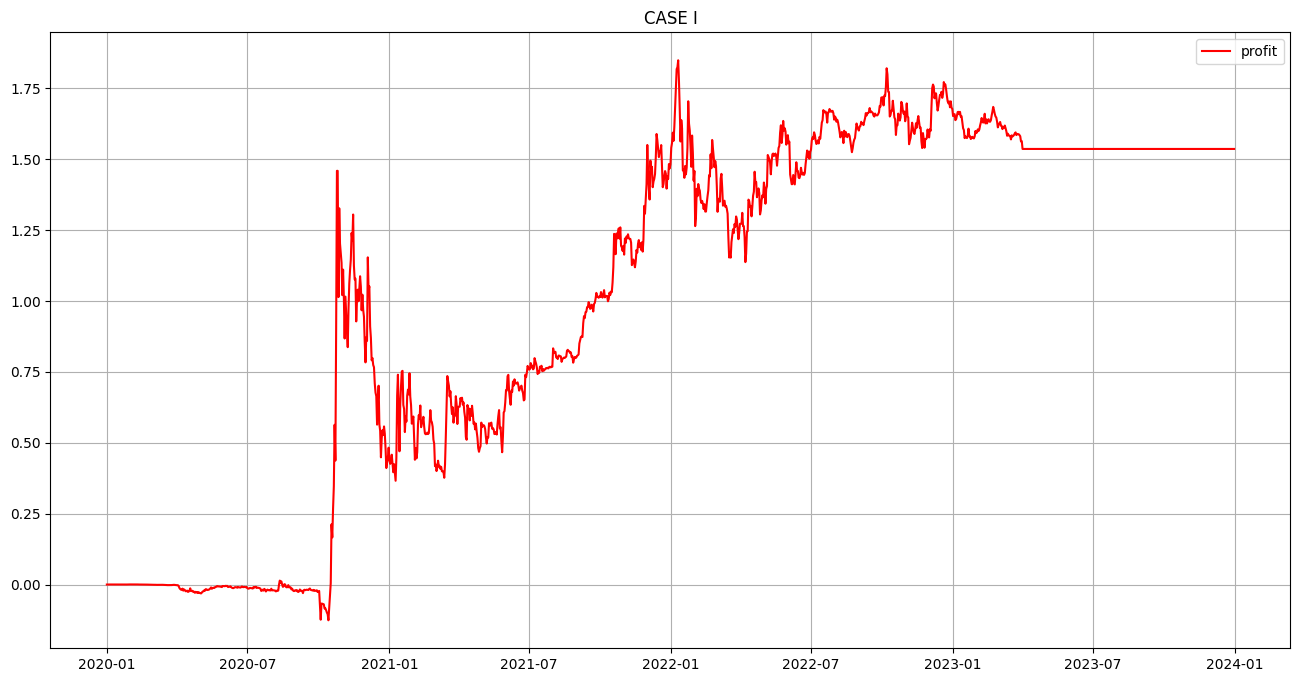

In [24]:
temp = d['BTCUSDT'].loc[startVery + trainingLen : endVery]
BS = None
fund = 1
tradeTimes = 0
enter = dict()
clear = dict()
Xlist = dict()
profit_list = pd.DataFrame(index=temp.index)
profit_list['profit'] = 0
profit_fee_list = pd.DataFrame(index=temp.index)
profit_fee_list['profit_fee'] = 0
profit_fee_list_realized = []
rets = []
c = 0.002

for x in range(len(selectedFinalName)):
    print('window:', x)
    name_P = selectedFinalName[x][0]
    name_Q = selectedFinalName[x][1]
    
    startTesting = startVery + trainingLen + movingLen * x
    endTesting = startTesting + testingLen

    print(startTesting, endTesting)

    logP = d[name_P]['logPrice'].loc[startTesting : endTesting]
    logQ = d[name_Q]['logPrice'].loc[startTesting : endTesting]

    slope, intercept, r_value, p_value, std_err = stats.linregress(logQ, logP)

    X = logP - slope * logQ
    n = len(X)
    Xlist[(name_P, name_Q)] = X

    tilde_a1_1 = paramFirst[x][0]
    tilde_a1_2 = paramFirst[x][1]
    tilde_b_1 = paramFirst[x][2]

    BS = None
    enter[x] = []
    clear[x] = []

    for i in range(n):
        if i == n - 1:
            if BS == 'B':
                profit_P = ((d[name_P]['close'][i - 1] - d[name_P]['close'][i]) / (1 + slope)) * (1 / (d[name_P]['close'][t] + d[name_Q]['close'][t]))
                profit_Q = ((slope * (d[name_Q]['close'][i] - d[name_Q]['close'][i - 1])) / (1 + slope)) * (1 / (d[name_P]['close'][t] + d[name_Q]['close'][t]))
                print("Clear Position at {} {} {} and {} {}".format(X.index[i], name_P, d[name_P]['close'][i], name_Q, d[name_Q]['close'][i]))
                print("trade completed")
                print("------------------------------------------------------------------------------")
                # Realized PnL
                profit = profit_Q + profit_P
                profit_fee_realized = profit_Q + profit_P - c * 2
                profit_list['profit'].loc[curTime] += profit
                profit_fee_list['profit_fee'].loc[curTime] += profit_fee_realized
                profit_fee_list_realized.append(profit_fee_realized)
                tradeTimes += 1
                clear[x].append(i)
                BS = None
            
            if BS == 'S':
                profit_P = ((d[name_P]['close'][i] - d[name_P]['close'][i - 1]) / (1 + slope)) * (1 / (d[name_P]['close'][t] + d[name_Q]['close'][t]))
                profit_Q = ((slope * (d[name_Q]['close'][i - 1] - d[name_Q]['close'][i])) / (1 + slope)) * (1 / (d[name_P]['close'][t] + d[name_Q]['close'][t]))
                print("Clear Position at {} {} {} and {} {}".format(X.index[i], name_P, d[name_P]['close'][i], name_Q, d[name_Q]['close'][i]))
                print("trade completed")
                print("------------------------------------------------------------------------------")
                profit = profit_Q + profit_P
                profit_fee_realized = profit_Q + profit_P - c * 2
                profit_list['profit'].loc[curTime] += profit
                profit_fee_list['profit_fee'].loc[curTime] += profit_fee_realized
                profit_fee_list_realized.append(profit_fee_realized)
                tradeTimes += 1
                clear[x].append(i)
                BS = None

            break
        
        curTime = X.index[i]
        
        ## 進場邏輯
        entryLong = X[i] >= tilde_a1_1 # short P, long beta Q
        exitLong = X[i] <= tilde_b_1
        entryShort = X[i] <= tilde_a1_2 # long P, short beta Q
        exitShort = X[i] >= tilde_b_1

        if BS == 'B':
            profit_P = ((d[name_P]['close'][i - 1] - d[name_P]['close'][i]) / (1 + slope)) * (1 / (d[name_P]['close'][t] + d[name_Q]['close'][t]))
            profit_Q = ((slope * (d[name_Q]['close'][i] - d[name_Q]['close'][i - 1])) / (1 + slope)) * (1 / (d[name_P]['close'][t] + d[name_Q]['close'][t]))
            # Realized PnL
            profit = profit_Q + profit_P
            profit_fee_realized = profit_Q + profit_P 
            profit_list['profit'].loc[curTime] += profit
            profit_fee_list['profit_fee'].loc[curTime] += profit_fee_realized
            profit_fee_list_realized.append(profit_fee_realized)
            if exitLong:
                print("Clear Position at {} {} {} and {} {}".format(X.index[i], name_P, d[name_P]['close'][i], name_Q, d[name_Q]['close'][i]))
                print("trade completed")
                print("------------------------------------------------------------------------------")
                profit_fee_list['profit_fee'].loc[curTime] -= c
                tradeTimes += 1
                clear[x].append(i)
                BS = None
        
        if BS == 'S':
            profit_P = ((d[name_P]['close'][i] - d[name_P]['close'][i - 1]) / (1 + slope)) * (1 / (d[name_P]['close'][t] + d[name_Q]['close'][t]))
            profit_Q = ((slope * (d[name_Q]['close'][i - 1] - d[name_Q]['close'][i])) / (1 + slope)) * (1 / (d[name_P]['close'][t] + d[name_Q]['close'][t]))
            profit = profit_Q + profit_P
            profit_fee_realized = profit_Q + profit_P
            profit_list['profit'].loc[curTime] += profit
            profit_fee_list['profit_fee'].loc[curTime] += profit_fee_realized
            profit_fee_list_realized.append(profit_fee_realized)
            if exitShort:
                print("Clear Position at {} {} {} and {} {}".format(X.index[i], name_P, d[name_P]['close'][i], name_Q, d[name_Q]['close'][i]))
                print("trade completed")
                print("------------------------------------------------------------------------------")
                tradeTimes += 1
                profit_fee_list['profit_fee'].loc[curTime] -= c
                clear[x].append(i)
                BS = None

        if BS == None:
            if entryLong:
                BS = 'B'
                t = i
                enter[x].append(i)
                print("Enter Position")
                print("Short {}: {}, Long {}: {}, time: {}".format(name_P, d[name_P]['close'][t], name_Q, d[name_Q]['close'][t], X.index[t]))

            elif entryShort:
                BS = 'S'
                t = i
                enter[x].append(i)
                print("Enter Position")
                print("Long {}: {}, Short {}: {}, time: {}".format(name_P, d[name_P]['close'][t], name_Q, d[name_Q]['close'][t], X.index[t]))
        realized = False
    print('\n')


profit_list['cumSum'] = profit_list['profit'].cumsum()
profit_fee_list['cumSum'] = profit_fee_list['profit_fee'].cumsum()
equity = pd.DataFrame(index=temp.index)
equity['profit'] = profit_list['cumSum']
equity['profitfee'] = profit_fee_list['cumSum']
print(equity)
plt.figure(figsize=(16, 8))
plt.plot(equity['profitfee'], label = 'profit', color = 'red')
plt.title("CASE I")
plt.grid('True')
plt.legend()
plt.show()

Profit :  1.5360439695878725
Return :  1.5360439695878725
Max DrawDown :  0.44447980430910894
Caimar Ratio :  3.455823987268601
Trade Times :  49
Win Rate :  0.4983388704318937
Profit Factor :  1.119533165545075


Text(0.5, 1.0, 'CASE I')

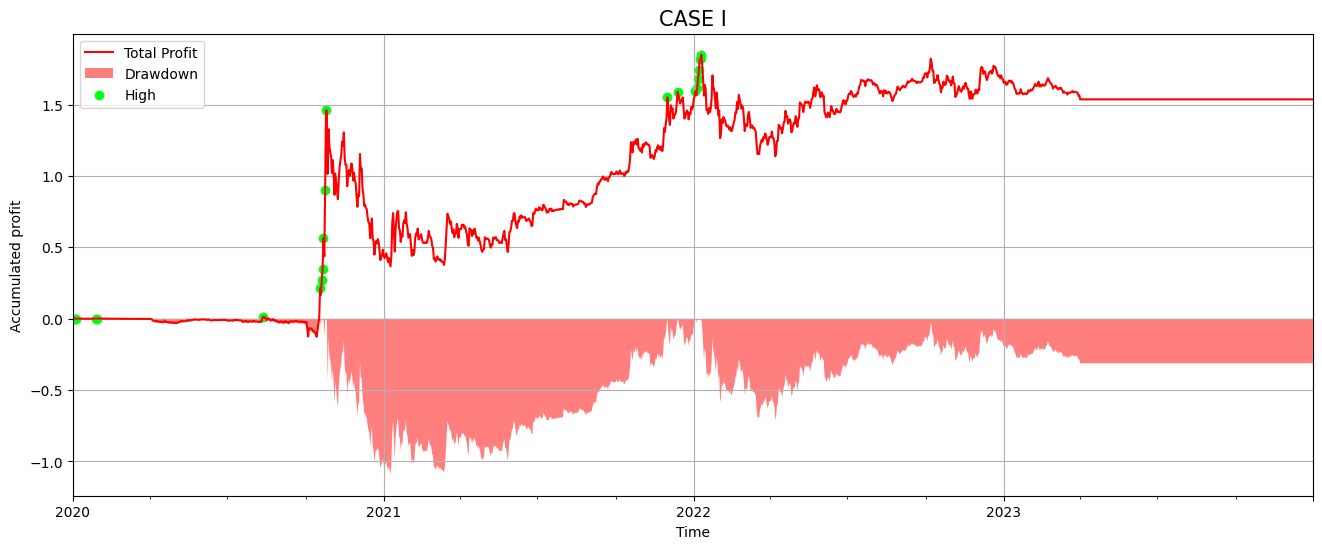

In [25]:
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity']/equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax() #前n個元素的最大值
#print(profit_fee_list_realized)
profit = equity['profitfee'].iloc[-1]
ret = equity['equity'][-1]/equity['equity'][0] - 1
mdd = abs(equity['drawdown_percent'].min())
calmarRatio = ret / mdd
winRate = len([i for i in profit_fee_list_realized if i >= 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i>0]) / abs(sum([i for i in profit_fee_list_realized if i<0]))

print('Profit : ',profit)
print('Return : ',ret)
print('Max DrawDown : ',mdd)
print('Caimar Ratio : ',calmarRatio)
print('Trade Times : ',tradeTimes)
print('Win Rate : ',winRate)
print('Profit Factor : ',profitFactor)

fig, ax = plt.subplots(figsize = (16, 6))
high_index = equity[equity['profitfee'].cummax() == equity['profitfee']].index
equity['profitfee'].plot(label = 'Total Profit', ax = ax, color = 'red', grid = True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor = 'red', label = 'Drawdown', alpha = 0.5)
plt.scatter(high_index, equity['profitfee'].loc[high_index], color = '#02ff0f', label = 'High')

plt.legend()
plt.ylabel('Accumulated profit')
plt.xlabel('Time')
plt.title('CASE I', fontsize = 15)

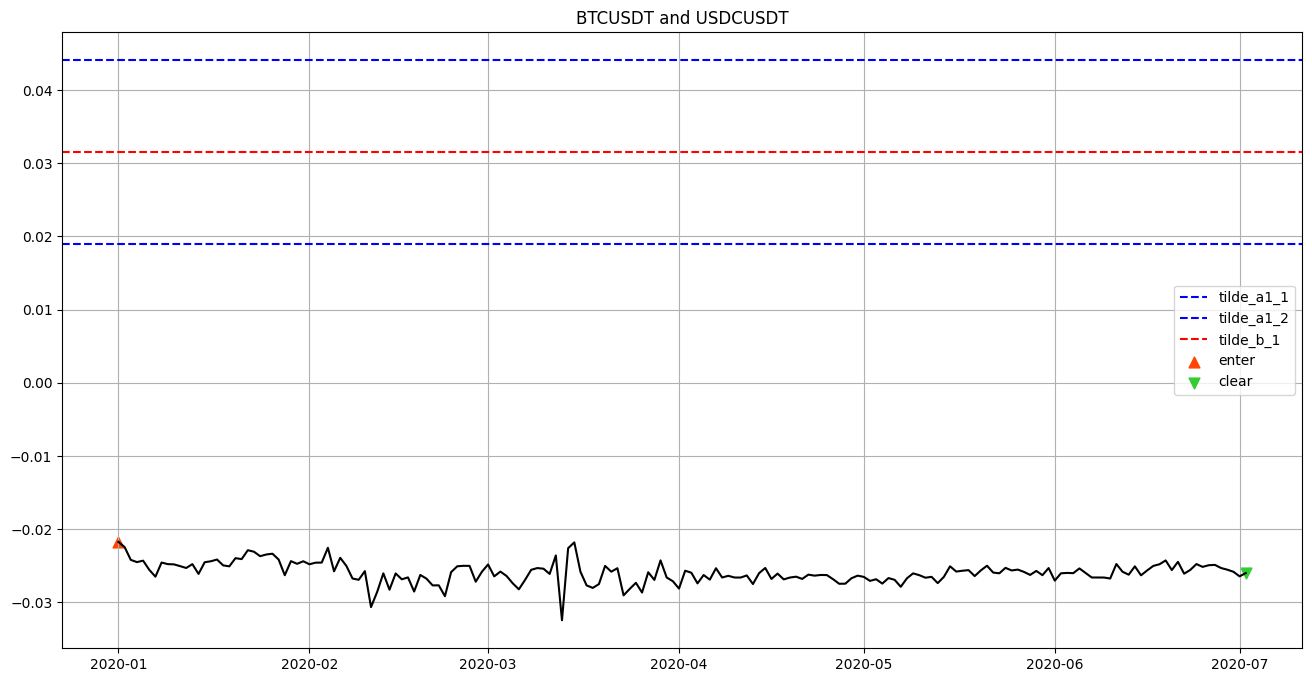

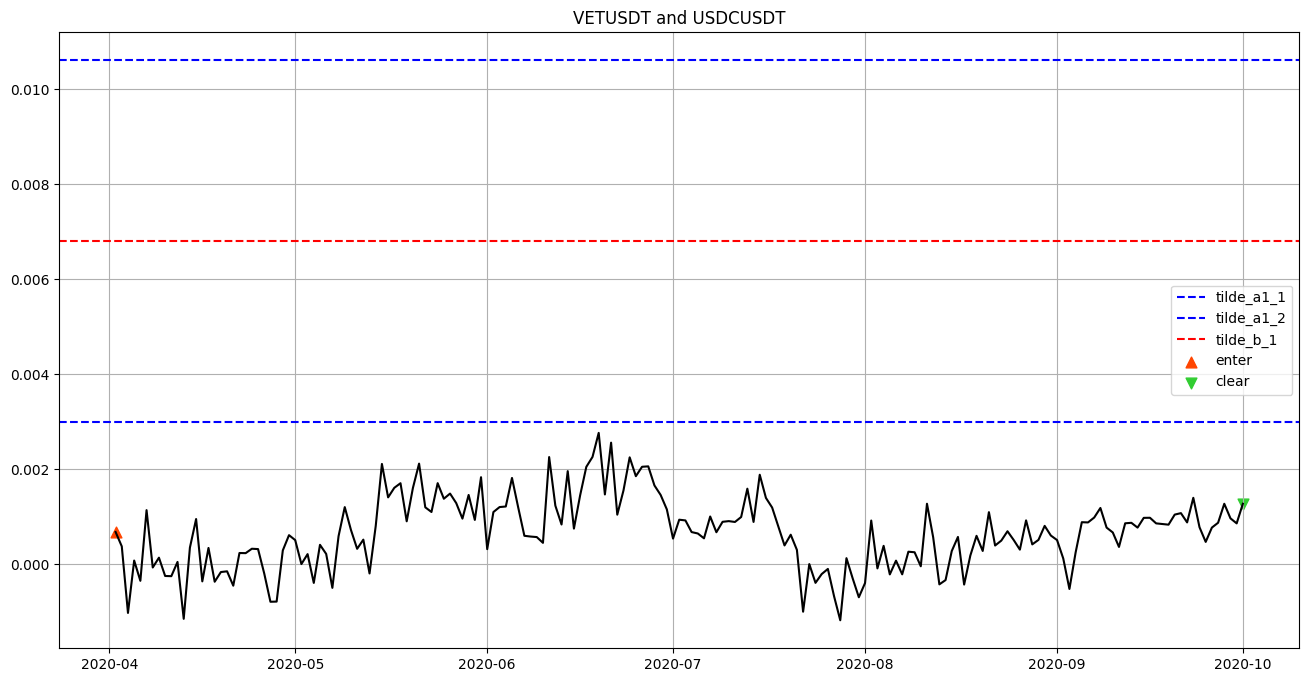

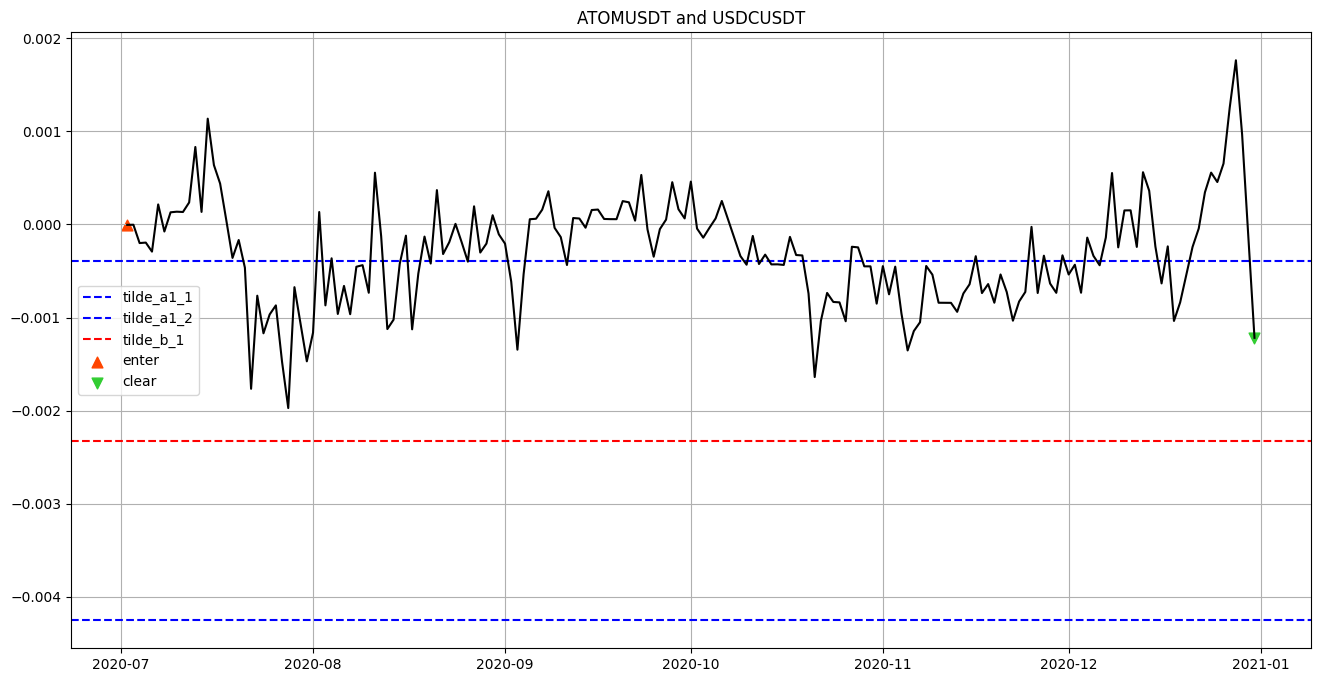

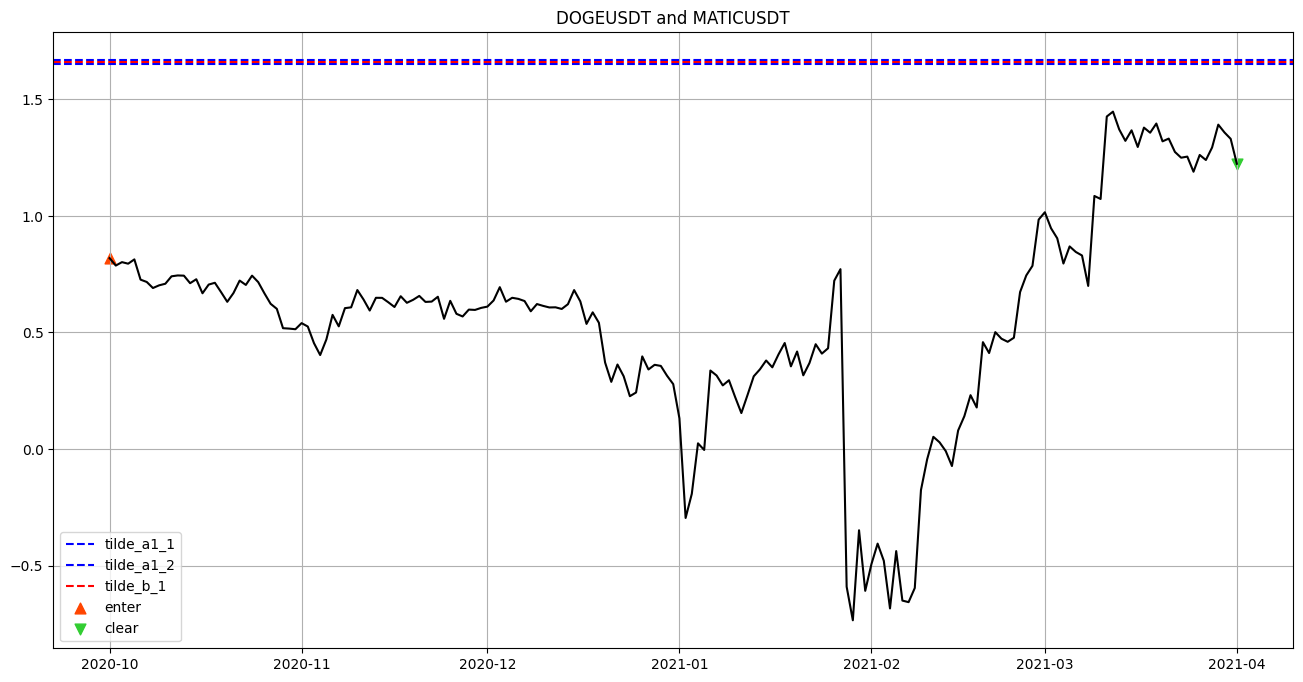

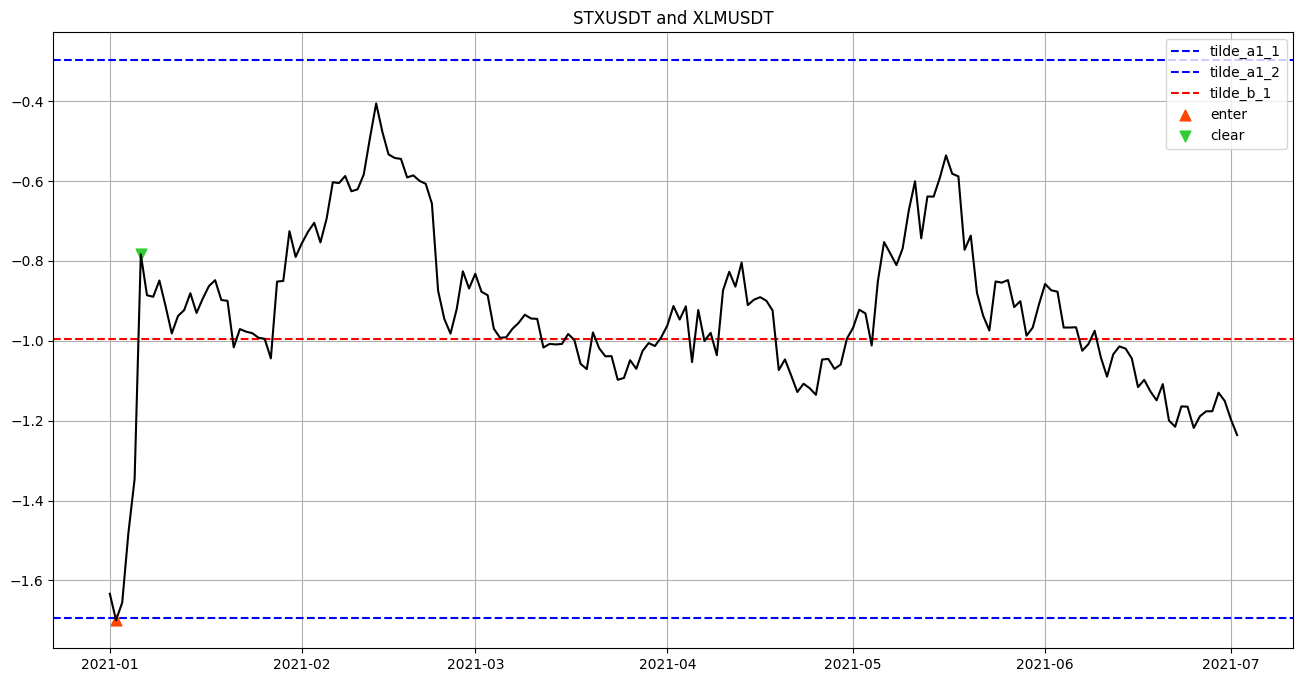

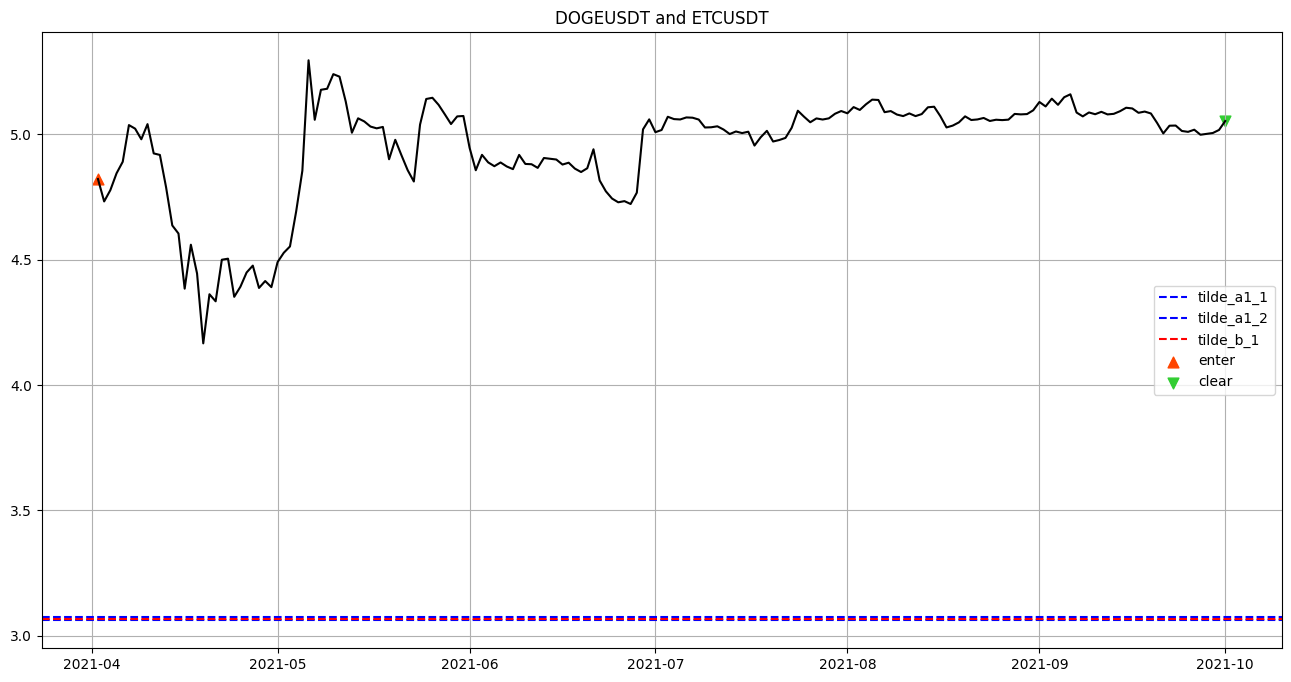

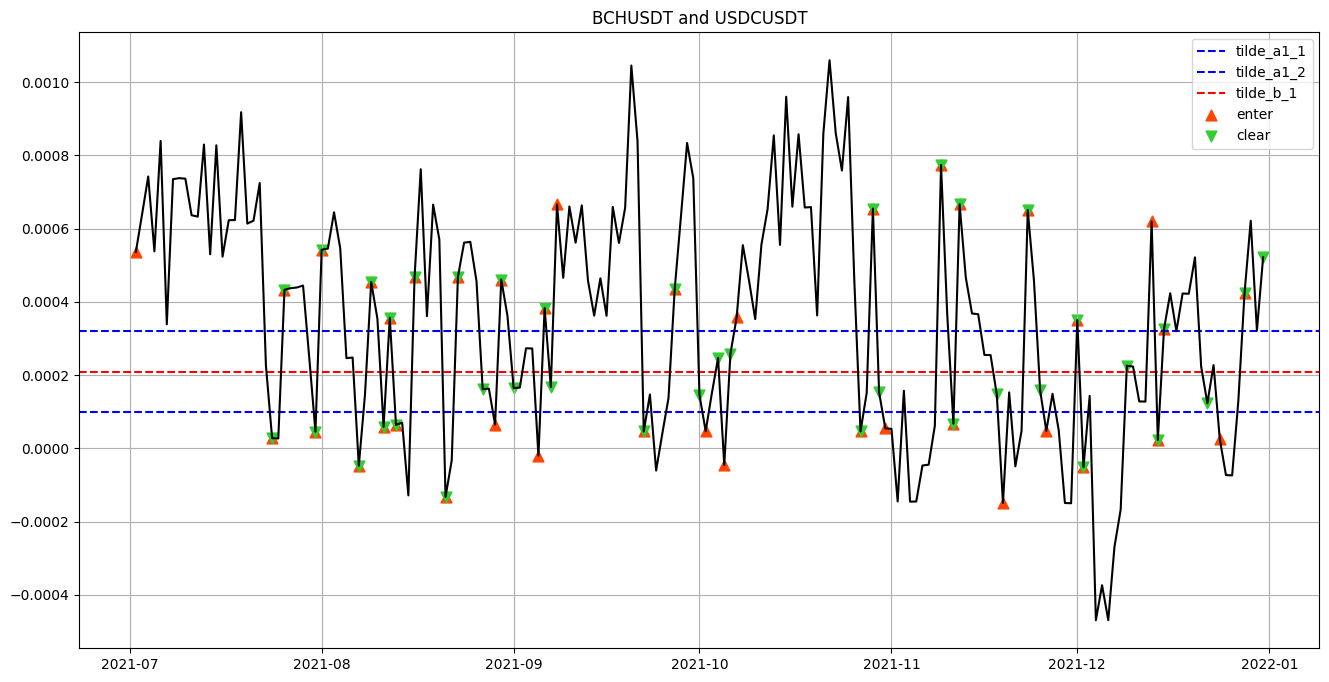

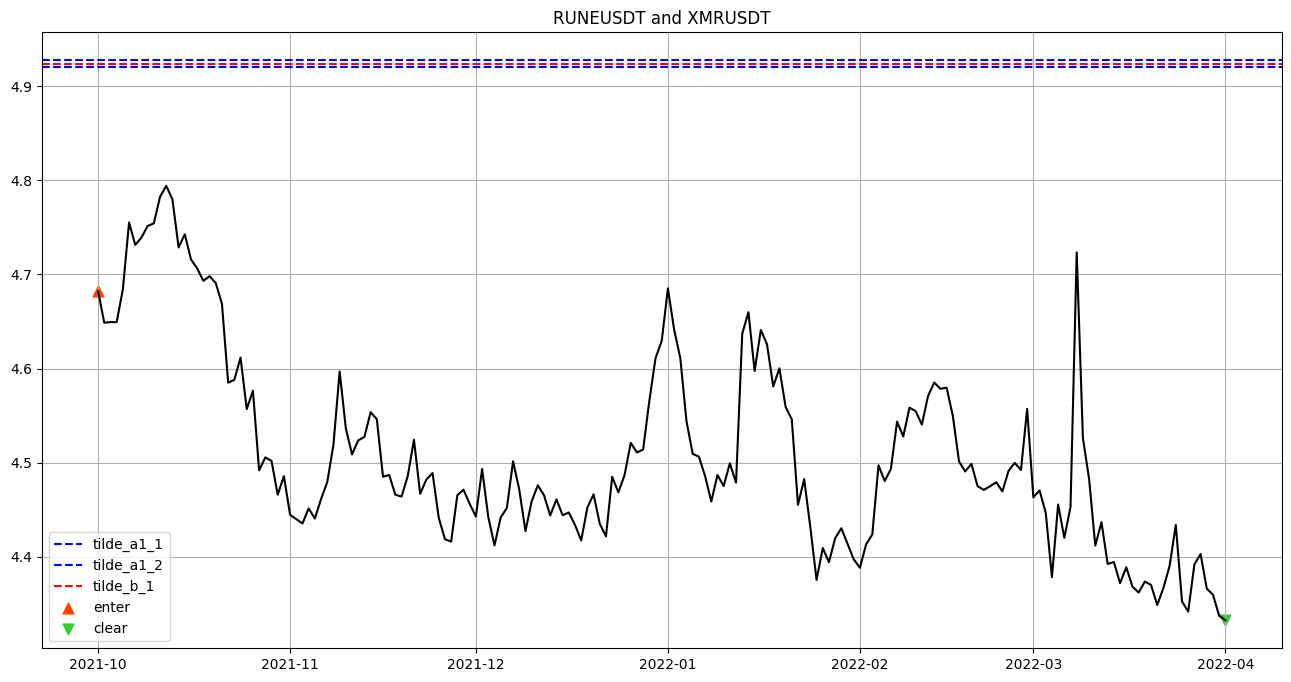

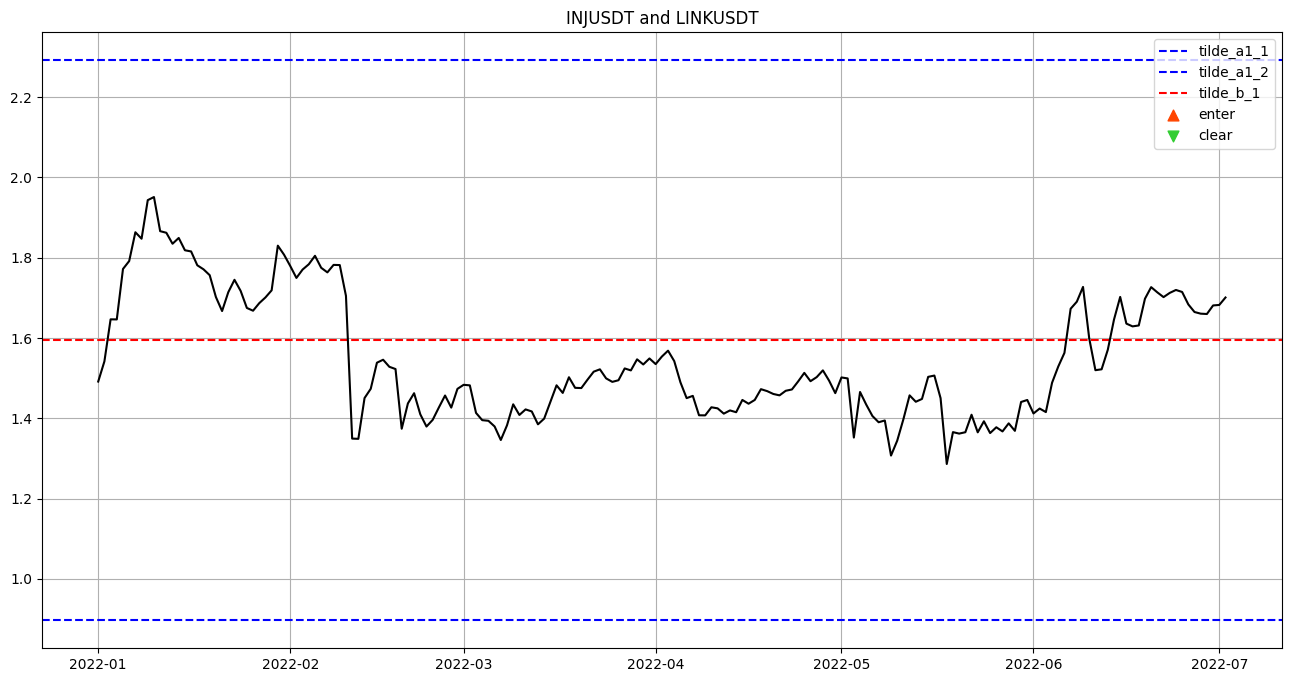

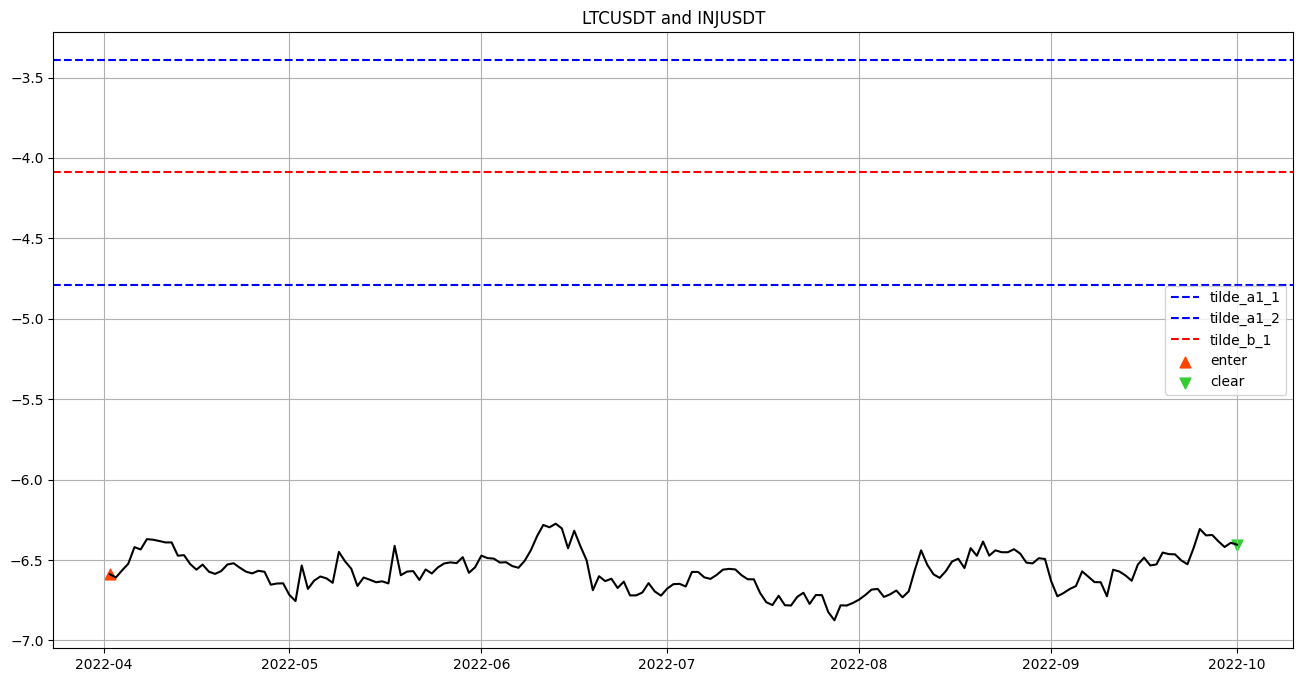

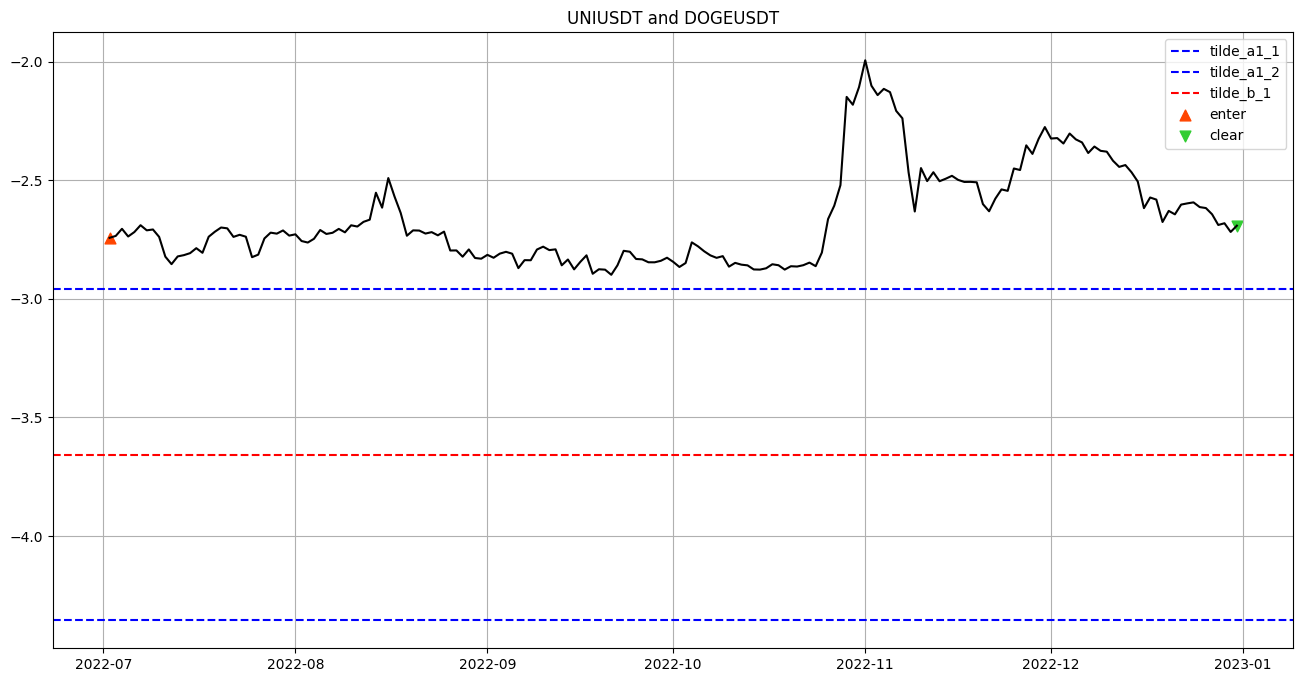

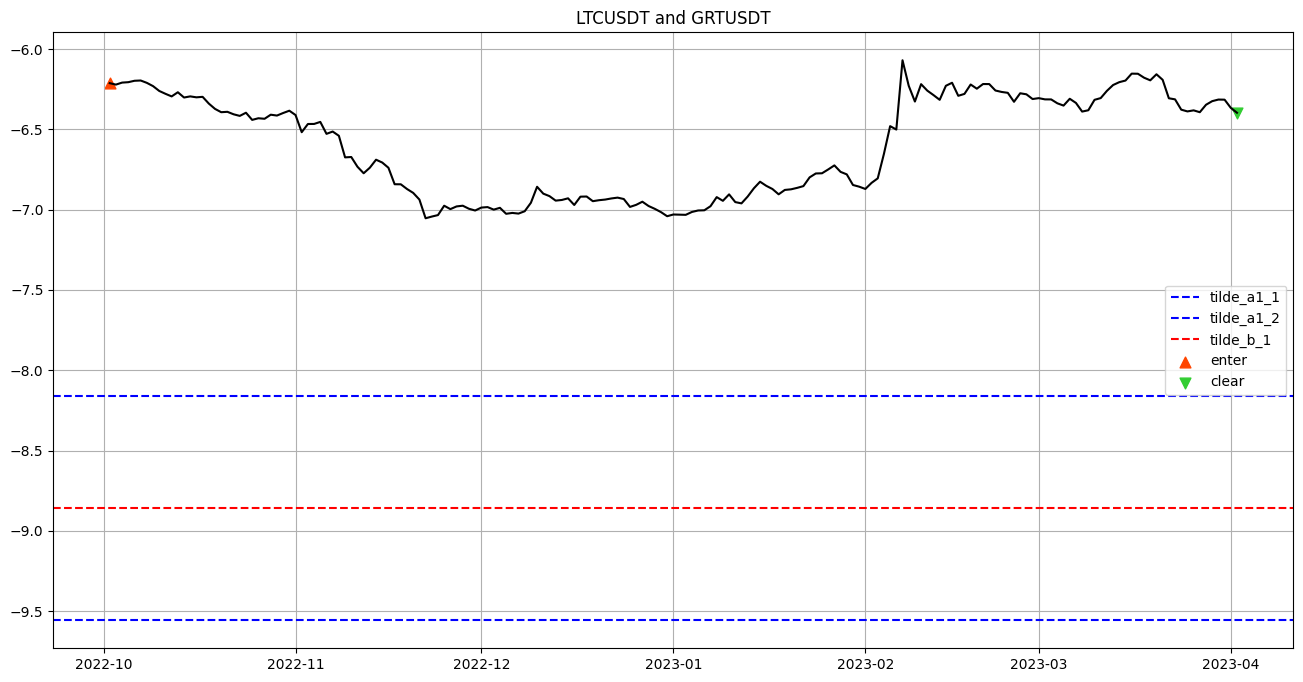

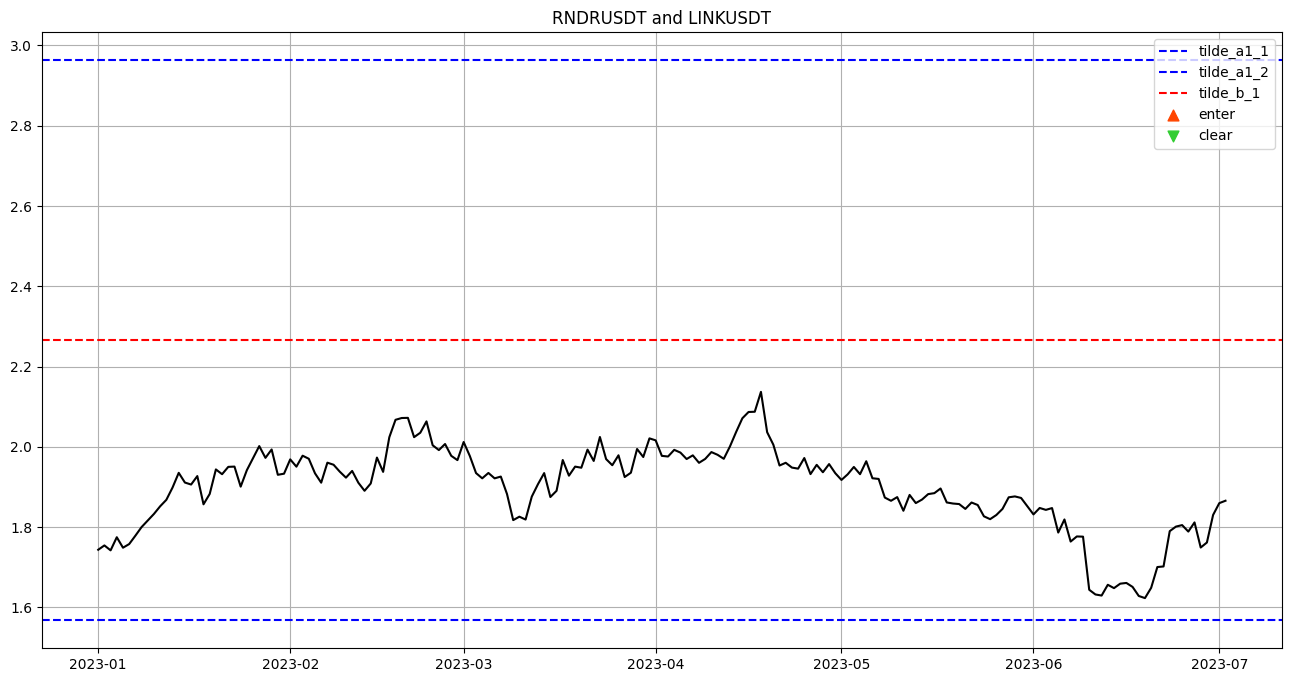

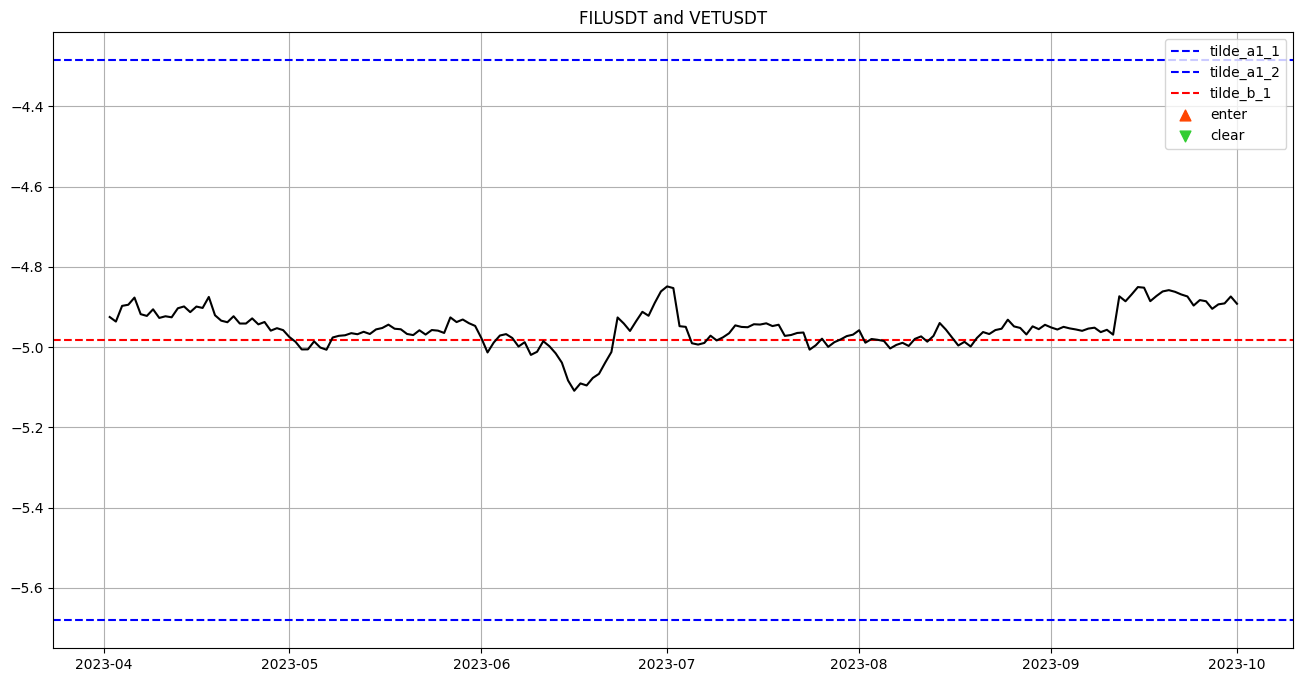

In [26]:
for x in range(intervalNum):
    plt.figure(figsize=(16, 8))
    
    name_P = selectedFinalName[x][0]
    name_Q = selectedFinalName[x][1]
    
    X = Xlist[(name_P, name_Q)]
    
    tilde_a1_1 = paramFirst[x][0]
    tilde_a1_2 = paramFirst[x][1]
    tilde_b_1 = paramFirst[x][2]

    plt.axhline(y = tilde_a1_1, color = 'blue', linestyle = '--', label = 'tilde_a1_1')
    plt.axhline(y = tilde_a1_2, color = 'blue', linestyle = '--', label = 'tilde_a1_2')
    plt.axhline(y = tilde_b_1, color = 'red', linestyle = '--', label = 'tilde_b_1')
    
    e = enter[x]
    c = clear[x]
    plt.scatter(X.iloc[e].index, X.iloc[e],c = 'orangered', label = 'enter', marker='^', s=60)
    plt.scatter(X.iloc[c].index, X.iloc[c],c = 'limegreen', label = 'clear', marker='v', s=60)

    plt.grid('True')
    plt.legend()

    plt.title(f"{name_Q} and {name_P}")
    plt.plot(X, label = 'spread', color = 'black')

window: 0
2020-01-01 00:00:00 2020-07-02 00:00:00
Enter Position
Long USDCUSDT: 1.0114, Short BTCUSDT: 4285.08, time: 2020-01-01 00:00:00
Clear Position at 2020-07-02 00:00:00 USDCUSDT 0.9975 and BTCUSDT 10159.98
trade completed
------------------------------------------------------------------------------


window: 1
2020-04-01 06:47:08.571429 2020-10-01 06:47:08.571429
Enter Position
Long USDCUSDT: 1.0114, Short VETUSDT: 0.02115, time: 2020-04-02 00:00:00
Clear Position at 2020-10-01 00:00:00 USDCUSDT 0.9953 and VETUSDT 0.004358
trade completed
------------------------------------------------------------------------------


window: 2
2020-07-01 13:34:17.142858 2020-12-31 13:34:17.142858
Enter Position
Short USDCUSDT: 1.0114, Long ATOMUSDT: 3.777, time: 2020-07-02 00:00:00
Clear Position at 2020-12-31 00:00:00 USDCUSDT 0.9953 and ATOMUSDT 3.1
trade completed
------------------------------------------------------------------------------


window: 3
2020-09-30 20:21:25.714287 2021-04-01

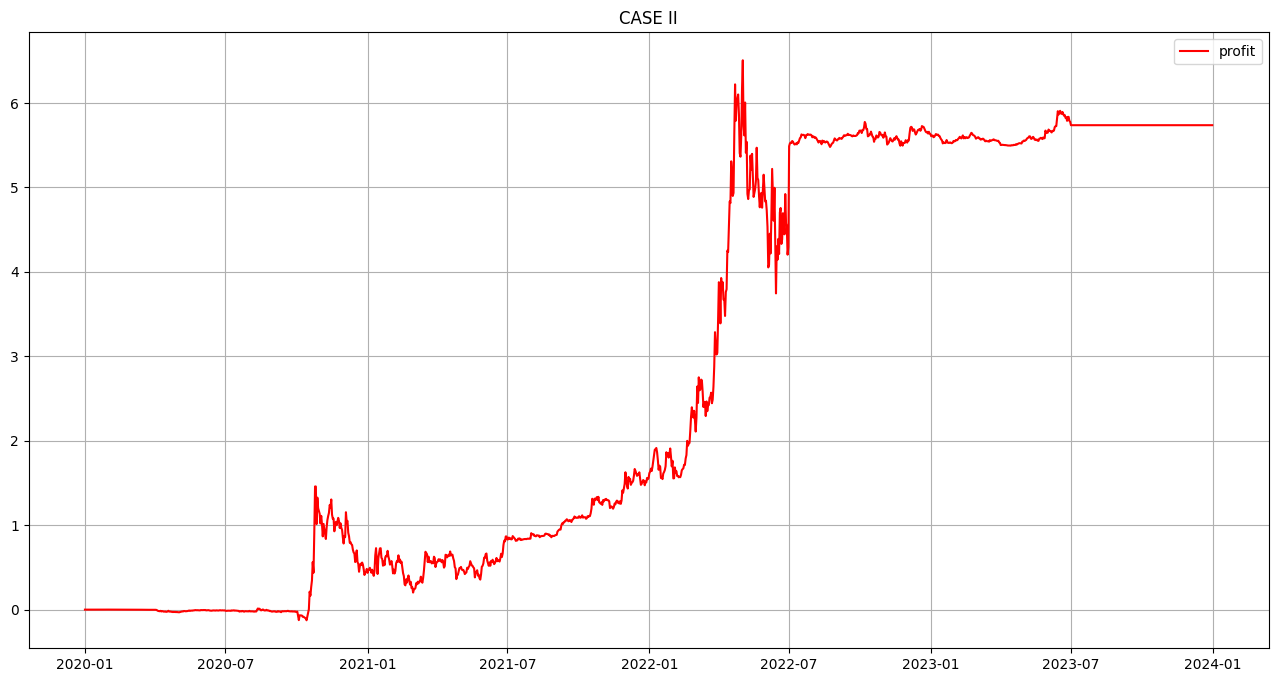

In [27]:
temp = d['BTCUSDT'].loc[startVery + trainingLen : endVery]
BS = None
fund = 1
tradeTimes = 0
enter = dict()
clear = dict()
Xlist = dict()
profit_list = pd.DataFrame(index=temp.index)
profit_list['profit'] = 0
profit_fee_list = pd.DataFrame(index=temp.index)
profit_fee_list['profit_fee'] = 0
profit_fee_list_realized = []
rets = []
c = 0.002

for x in range(len(selectedFinalName)):
    print('window:', x)
    name_P = selectedFinalName[x][0]
    name_Q = selectedFinalName[x][1]
    
    startTesting = startVery + trainingLen + movingLen * x
    endTesting = startTesting + testingLen

    print(startTesting, endTesting)

    logP = d[name_P]['logPrice'].loc[startTesting : endTesting]
    logQ = d[name_Q]['logPrice'].loc[startTesting : endTesting]

    slope, intercept, r_value, p_value, std_err = stats.linregress(logQ, logP)

    X = logP - slope * logQ
    n = len(X)
    Xlist[(name_P, name_Q)] = X

    tilde_a2_1 = paramSecond[x][0]
    tilde_a2_2 = paramSecond[x][1]

    BS = None
    enter[x] = []
    clear[x] = []

    for i in range(n):
        if i == n - 1:
            if BS == 'B':
                profit_P = ((d[name_P]['close'][i - 1] - d[name_P]['close'][i]) / (1 + slope)) * (1 / (d[name_P]['close'][t] + d[name_Q]['close'][t]))
                profit_Q = ((slope * (d[name_Q]['close'][i] - d[name_Q]['close'][i - 1])) / (1 + slope)) * (1 / (d[name_P]['close'][t] + d[name_Q]['close'][t]))
                print("Clear Position at {} {} {} and {} {}".format(X.index[i], name_P, d[name_P]['close'][i], name_Q, d[name_Q]['close'][i]))
                print("trade completed")
                print("------------------------------------------------------------------------------")
                # Realized PnL
                profit = profit_Q + profit_P
                profit_fee_realized = profit_Q + profit_P - c * 2
                profit_list['profit'].loc[curTime] += profit
                profit_fee_list['profit_fee'].loc[curTime] += profit_fee_realized
                profit_fee_list_realized.append(profit_fee_realized)
                tradeTimes += 1
                clear[x].append(i)
                BS = None
            
            if BS == 'S':
                profit_P = ((d[name_P]['close'][i] - d[name_P]['close'][i - 1]) / (1 + slope)) * (1 / (d[name_P]['close'][t] + d[name_Q]['close'][t]))
                profit_Q = ((slope * (d[name_Q]['close'][i - 1] - d[name_Q]['close'][i])) / (1 + slope)) * (1 / (d[name_P]['close'][t] + d[name_Q]['close'][t]))
                print("Clear Position at {} {} {} and {} {}".format(X.index[i], name_P, d[name_P]['close'][i], name_Q, d[name_Q]['close'][i]))
                print("trade completed")
                print("------------------------------------------------------------------------------")
                profit = profit_Q + profit_P
                profit_fee_realized = profit_Q + profit_P - c * 2
                profit_list['profit'].loc[curTime] += profit
                profit_fee_list['profit_fee'].loc[curTime] += profit_fee_realized
                profit_fee_list_realized.append(profit_fee_realized)
                tradeTimes += 1
                clear[x].append(i)
                BS = None

            break
        
        curTime = X.index[i]
        
        ## 進場邏輯
        entryLong = X[i] >= tilde_a2_1 # short P, long beta Q
        exitLong = X[i] <= tilde_a2_2
        entryShort = X[i] <= tilde_a2_2 # long P, short beta Q
        exitShort = X[i] >= tilde_a2_1

        if BS == 'B':
            profit_P = ((d[name_P]['close'][i - 1] - d[name_P]['close'][i]) / (1 + slope)) * (1 / (d[name_P]['close'][t] + d[name_Q]['close'][t]))
            profit_Q = ((slope * (d[name_Q]['close'][i] - d[name_Q]['close'][i - 1])) / (1 + slope)) * (1 / (d[name_P]['close'][t] + d[name_Q]['close'][t]))
            # Realized PnL
            profit = profit_Q + profit_P
            profit_fee_realized = profit_Q + profit_P 
            profit_list['profit'].loc[curTime] += profit
            profit_fee_list['profit_fee'].loc[curTime] += profit_fee_realized
            profit_fee_list_realized.append(profit_fee_realized)
            if exitLong:
                print("Clear Position at {} {} {} and {} {}".format(X.index[i], name_P, d[name_P]['close'][i], name_Q, d[name_Q]['close'][i]))
                print("trade completed")
                print("------------------------------------------------------------------------------")
                profit_fee_list['profit_fee'].loc[curTime] -= c
                tradeTimes += 1
                clear[x].append(i)
                BS = None
        
        if BS == 'S':
            profit_P = ((d[name_P]['close'][i] - d[name_P]['close'][i - 1]) / (1 + slope)) * (1 / (d[name_P]['close'][t] + d[name_Q]['close'][t]))
            profit_Q = ((slope * (d[name_Q]['close'][i - 1] - d[name_Q]['close'][i])) / (1 + slope)) * (1 / (d[name_P]['close'][t] + d[name_Q]['close'][t]))
            profit = profit_Q + profit_P
            profit_fee_realized = profit_Q + profit_P
            profit_list['profit'].loc[curTime] += profit
            profit_fee_list['profit_fee'].loc[curTime] += profit_fee_realized
            profit_fee_list_realized.append(profit_fee_realized)
            if exitShort:
                print("Clear Position at {} {} {} and {} {}".format(X.index[i], name_P, d[name_P]['close'][i], name_Q, d[name_Q]['close'][i]))
                print("trade completed")
                print("------------------------------------------------------------------------------")
                tradeTimes += 1
                profit_fee_list['profit_fee'].loc[curTime] -= c
                clear[x].append(i)
                BS = None

        if BS == None:
            if entryLong:
                BS = 'B'
                t = i
                enter[x].append(i)
                print("Enter Position")
                print("Short {}: {}, Long {}: {}, time: {}".format(name_P, d[name_P]['close'][t], name_Q, d[name_Q]['close'][t], X.index[t]))

            elif entryShort:
                BS = 'S'
                t = i
                enter[x].append(i)
                print("Enter Position")
                print("Long {}: {}, Short {}: {}, time: {}".format(name_P, d[name_P]['close'][t], name_Q, d[name_Q]['close'][t], X.index[t]))
        realized = False
    print('\n')


profit_list['cumSum'] = profit_list['profit'].cumsum()
profit_fee_list['cumSum'] = profit_fee_list['profit_fee'].cumsum()
equity = pd.DataFrame(index=temp.index)
equity['profit'] = profit_list['cumSum']
equity['profitfee'] = profit_fee_list['cumSum']
print(equity)
plt.figure(figsize=(16, 8))
plt.plot(equity['profitfee'], label = 'profit', color = 'red')
plt.title("CASE II")
plt.grid('True')
plt.legend()
plt.show()

Profit :  5.737587662307246
Return :  5.737587662307246
Max DrawDown :  0.5112208193946017
Caimar Ratio :  11.223305946541489
Trade Times :  50
Win Rate :  0.5023314963967783
Profit Factor :  1.1979895983132836


Text(0.5, 1.0, 'CASE II')

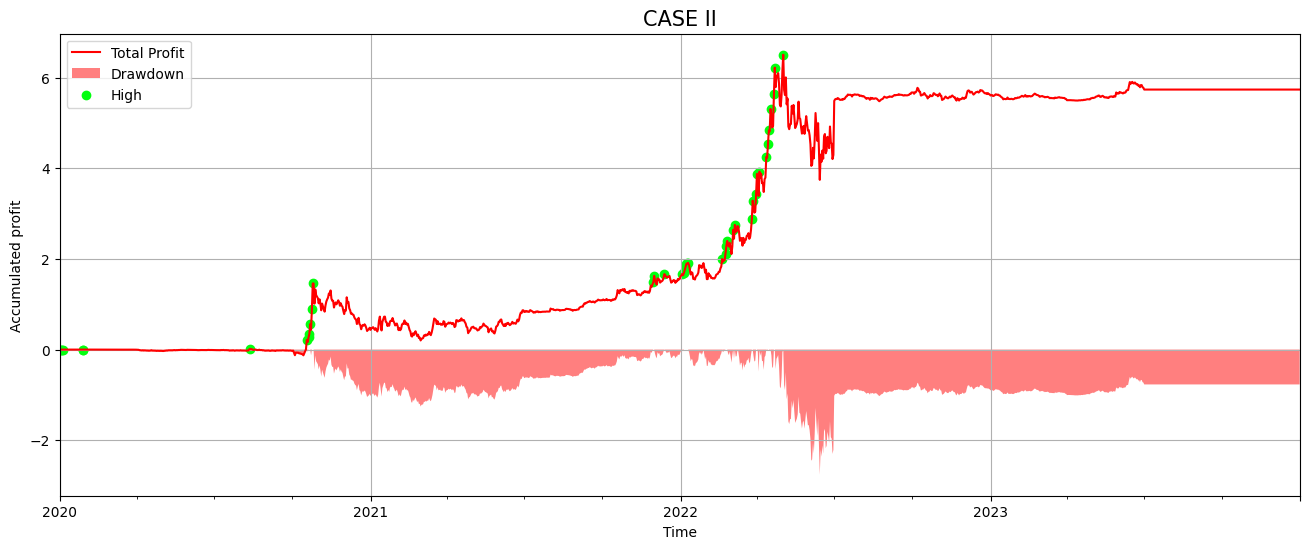

In [28]:
equity['equity'] = equity['profitfee'] + fund
equity['drawdown_percent'] = (equity['equity']/equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax() #前n個元素的最大值
#print(profit_fee_list_realized)
profit = equity['profitfee'].iloc[-1]
ret = equity['equity'][-1]/equity['equity'][0] - 1
mdd = abs(equity['drawdown_percent'].min())
calmarRatio = ret / mdd
winRate = len([i for i in profit_fee_list_realized if i >= 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i>0]) / abs(sum([i for i in profit_fee_list_realized if i<0]))

print('Profit : ',profit)
print('Return : ',ret)
print('Max DrawDown : ',mdd)
print('Caimar Ratio : ',calmarRatio)
print('Trade Times : ',tradeTimes)
print('Win Rate : ',winRate)
print('Profit Factor : ',profitFactor)

fig, ax = plt.subplots(figsize = (16, 6))
high_index = equity[equity['profitfee'].cummax() == equity['profitfee']].index
equity['profitfee'].plot(label = 'Total Profit', ax = ax, color = 'red', grid = True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'], 0, facecolor = 'red', label = 'Drawdown', alpha = 0.5)
plt.scatter(high_index, equity['profitfee'].loc[high_index], color = '#02ff0f', label = 'High')
plt.legend()
plt.ylabel('Accumulated profit')
plt.xlabel('Time')
plt.title('CASE II', fontsize = 15)

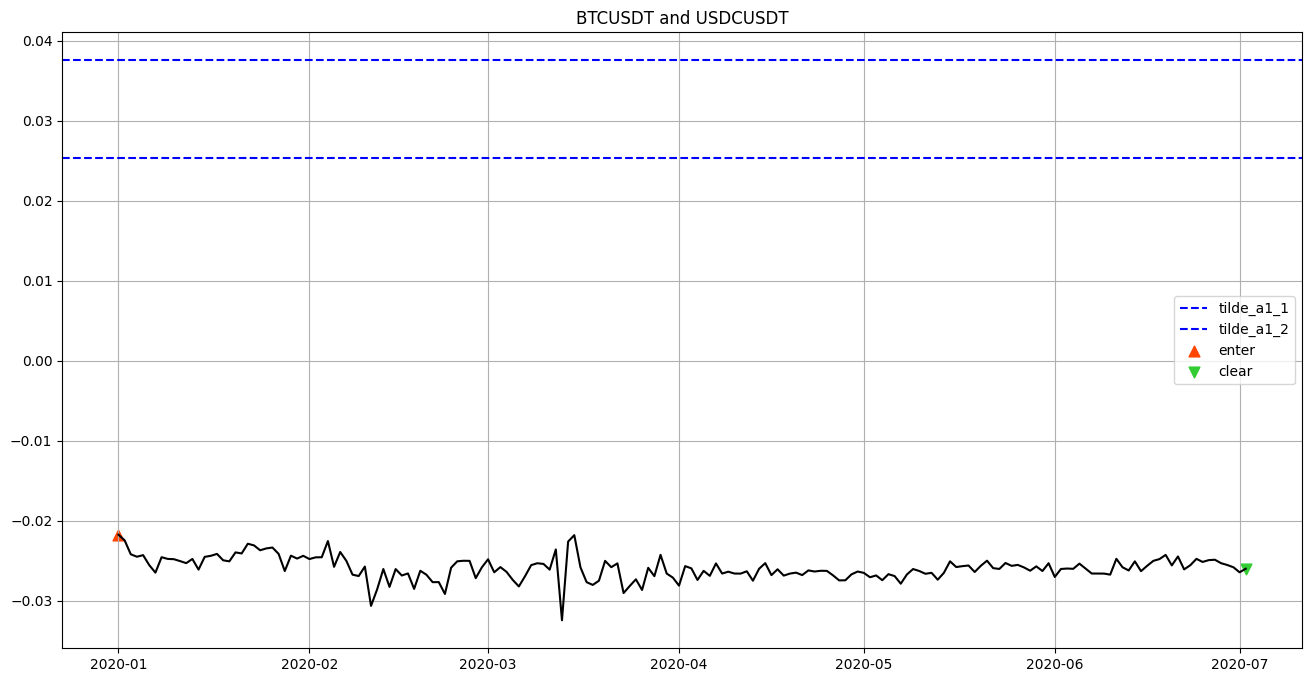

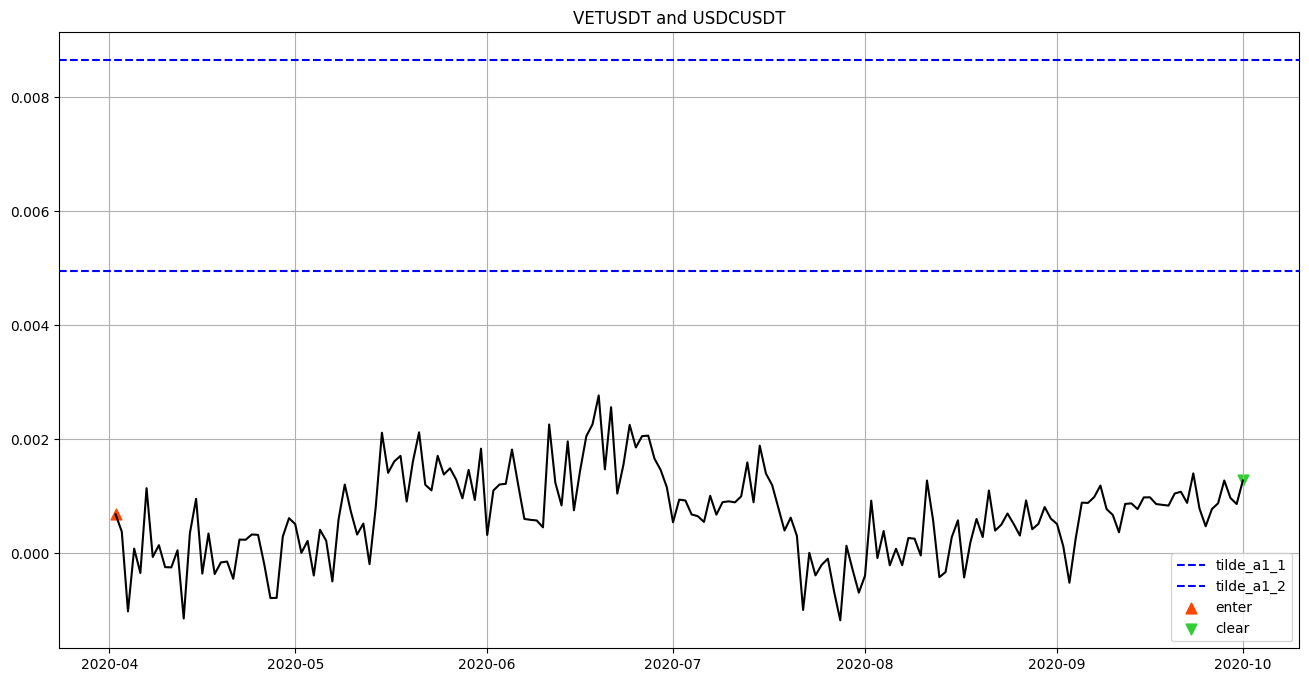

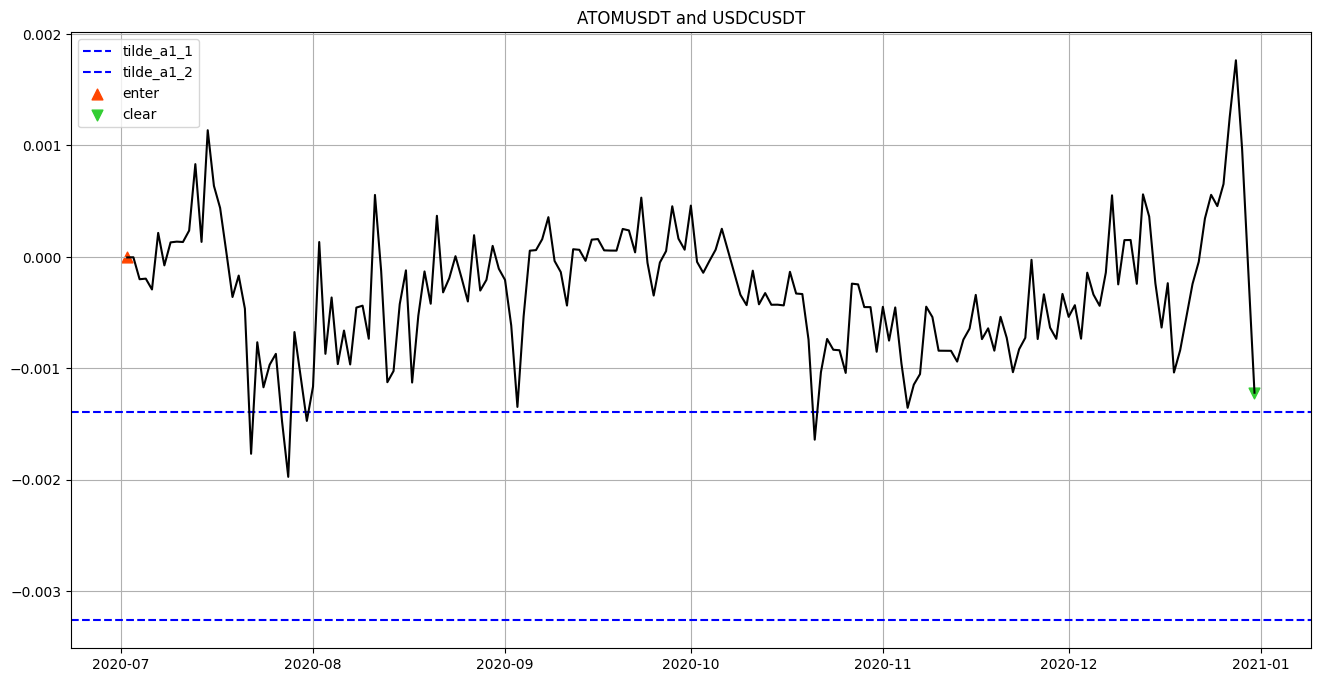

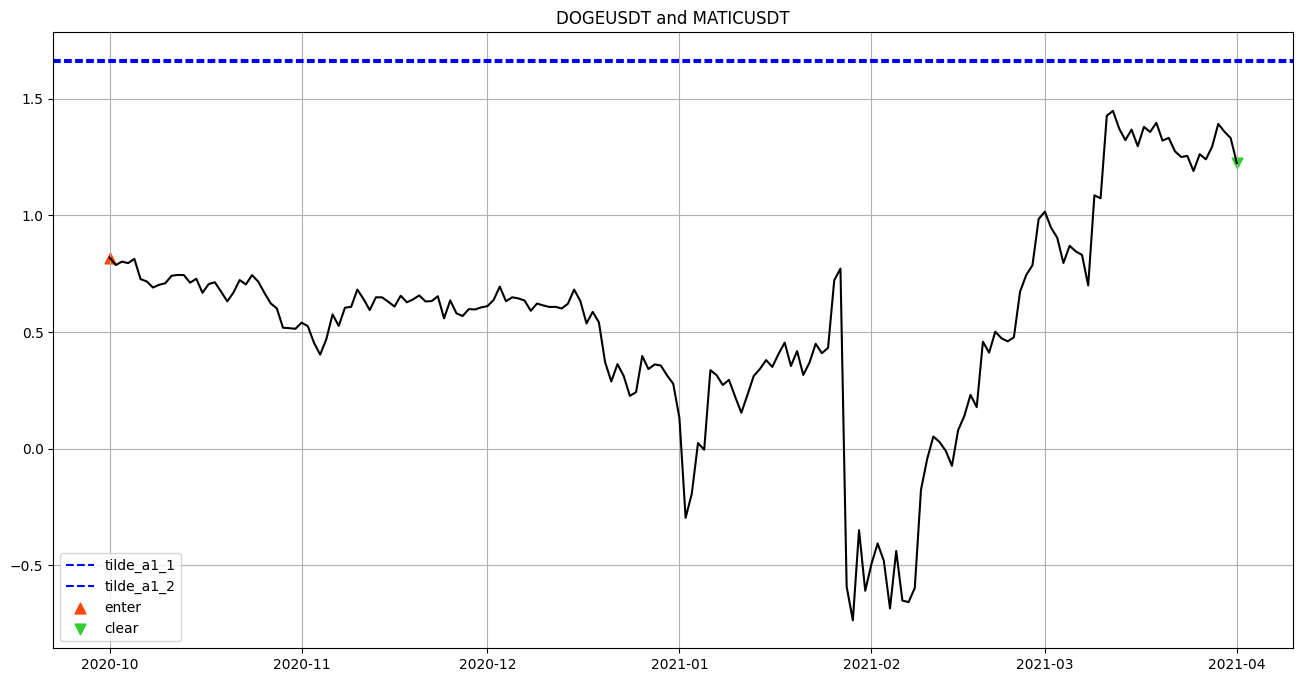

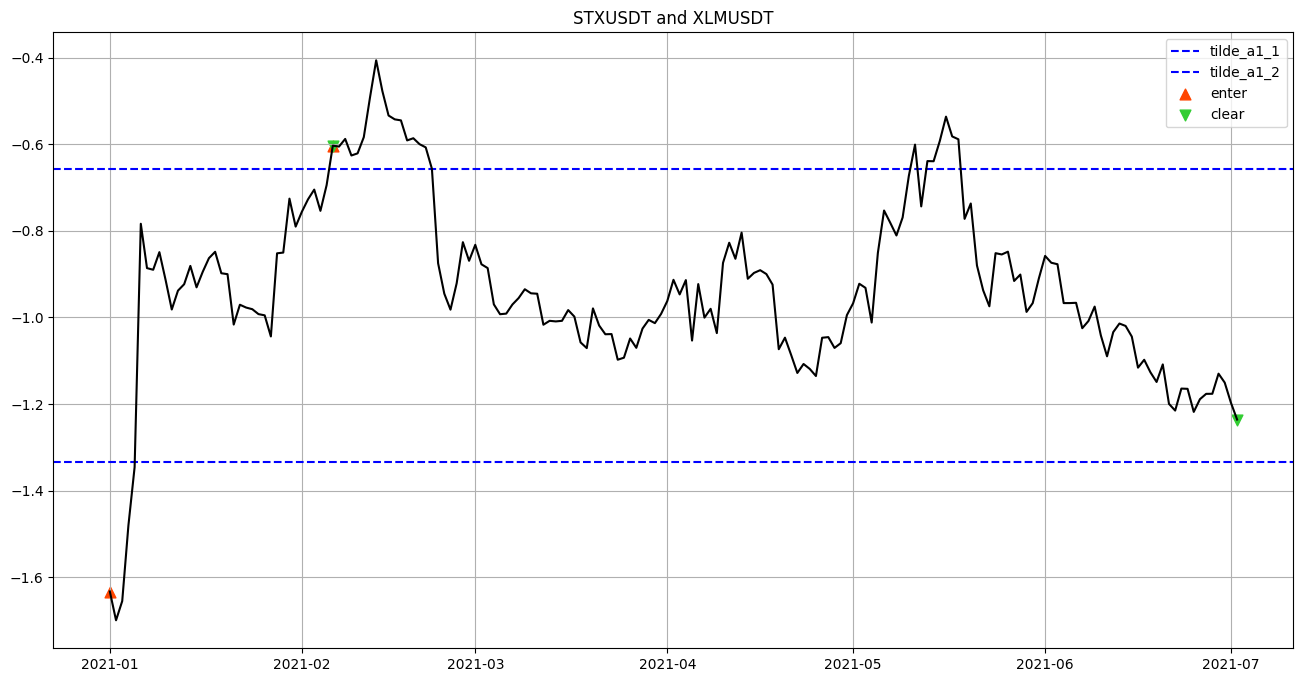

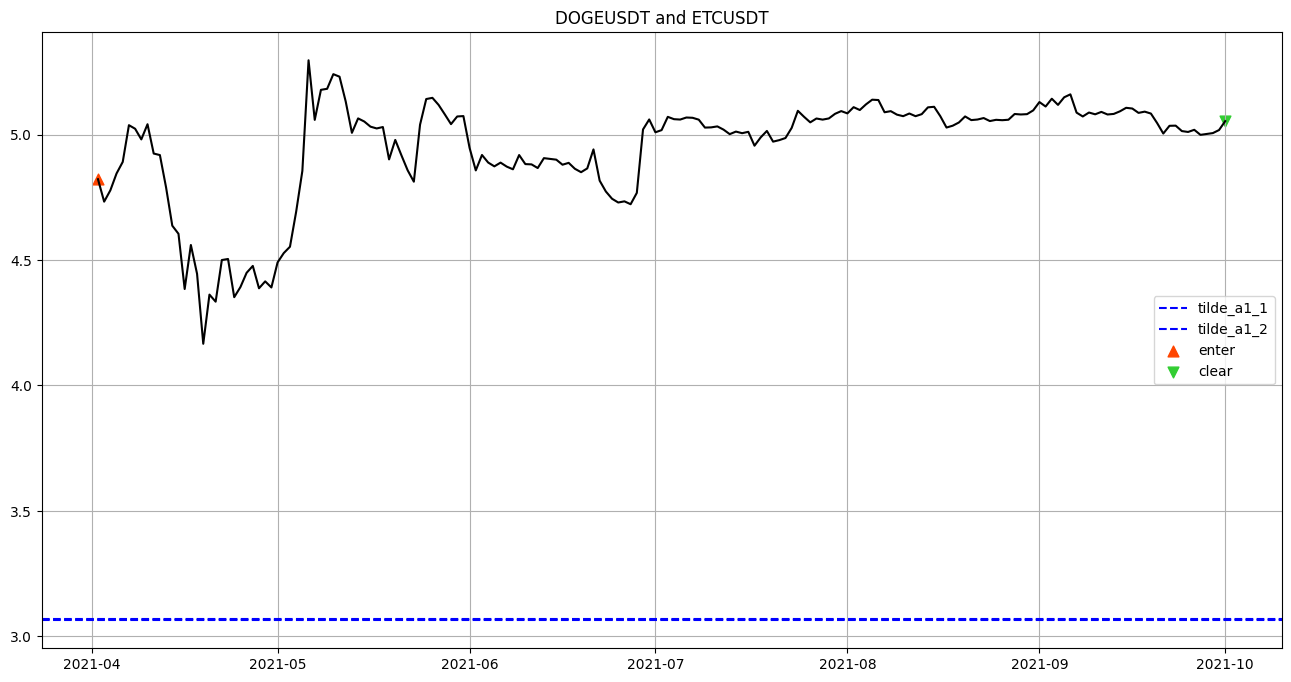

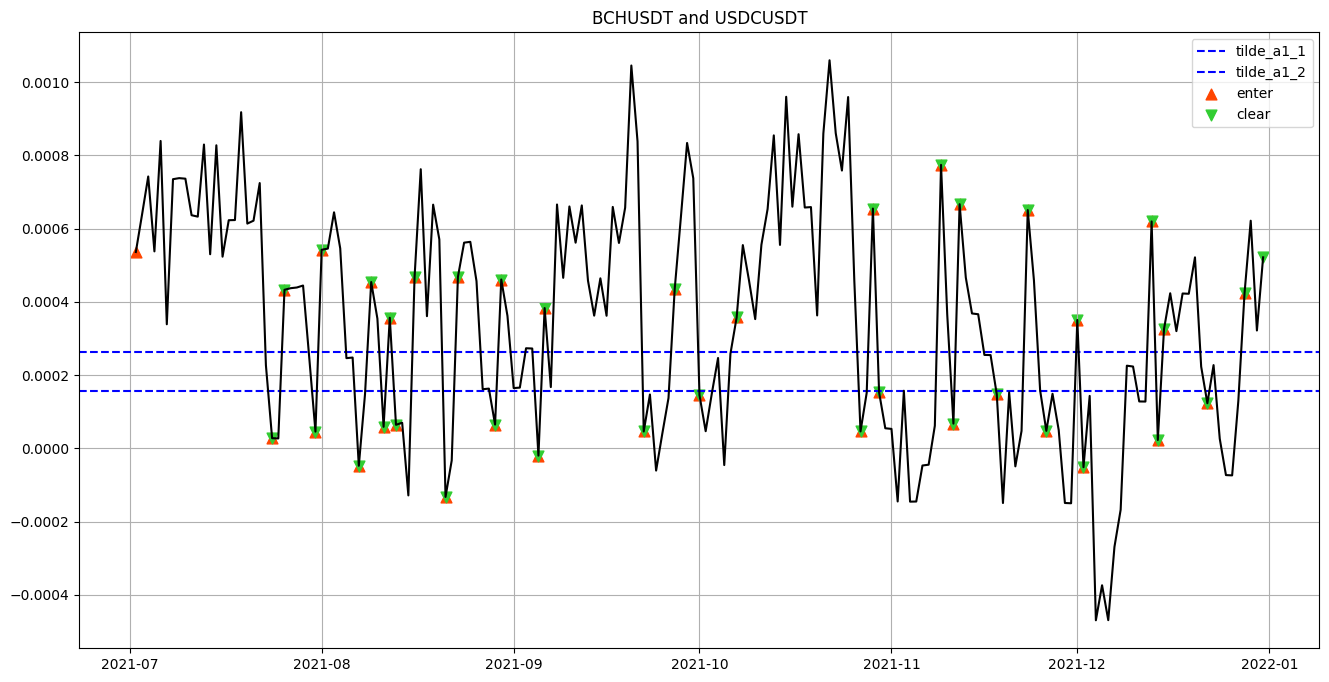

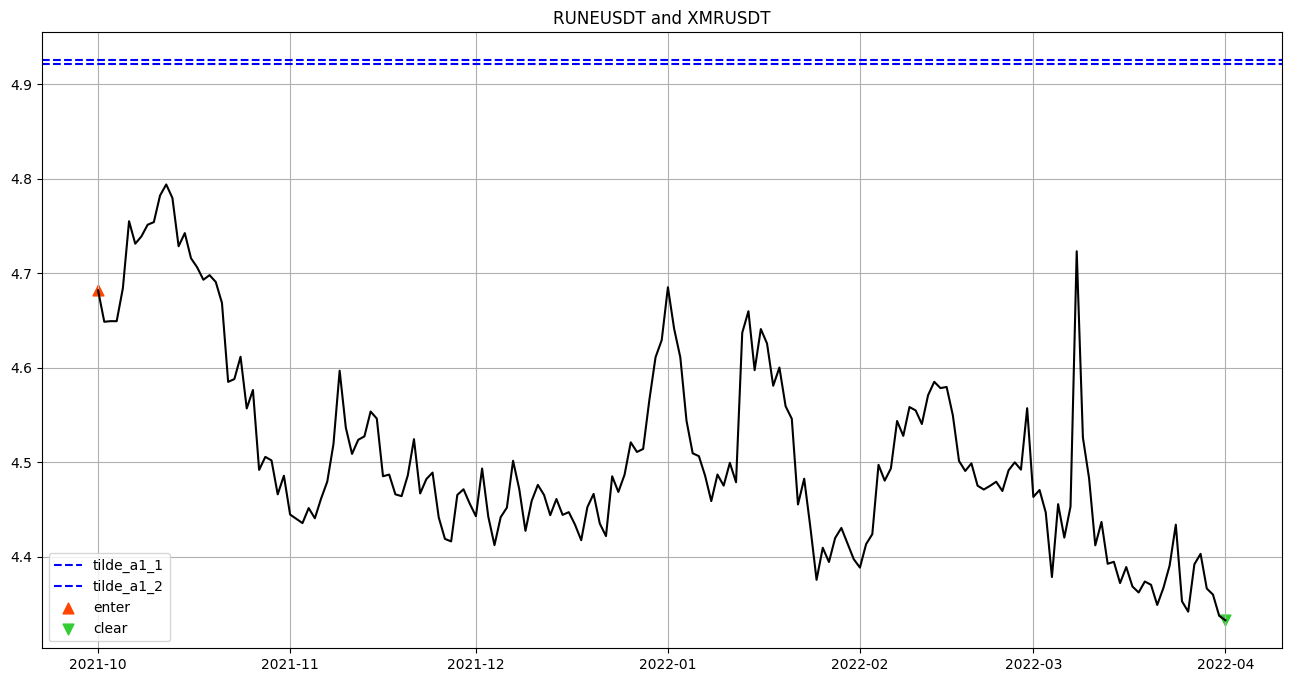

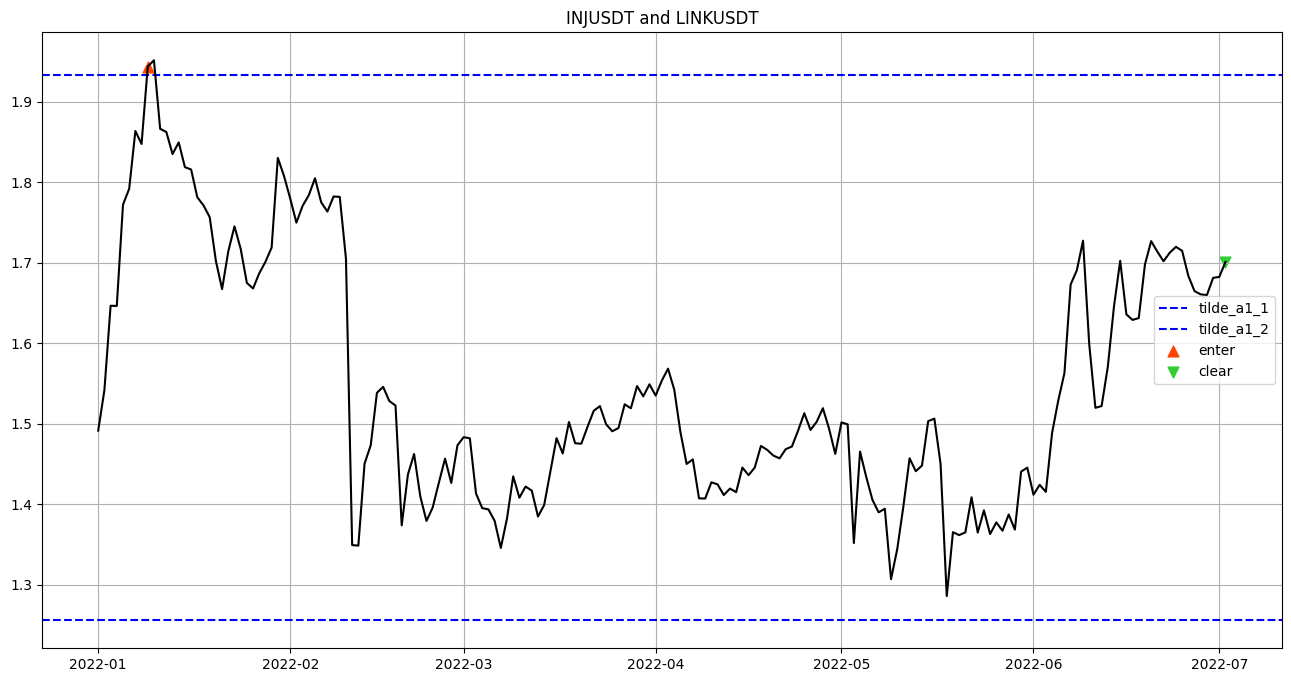

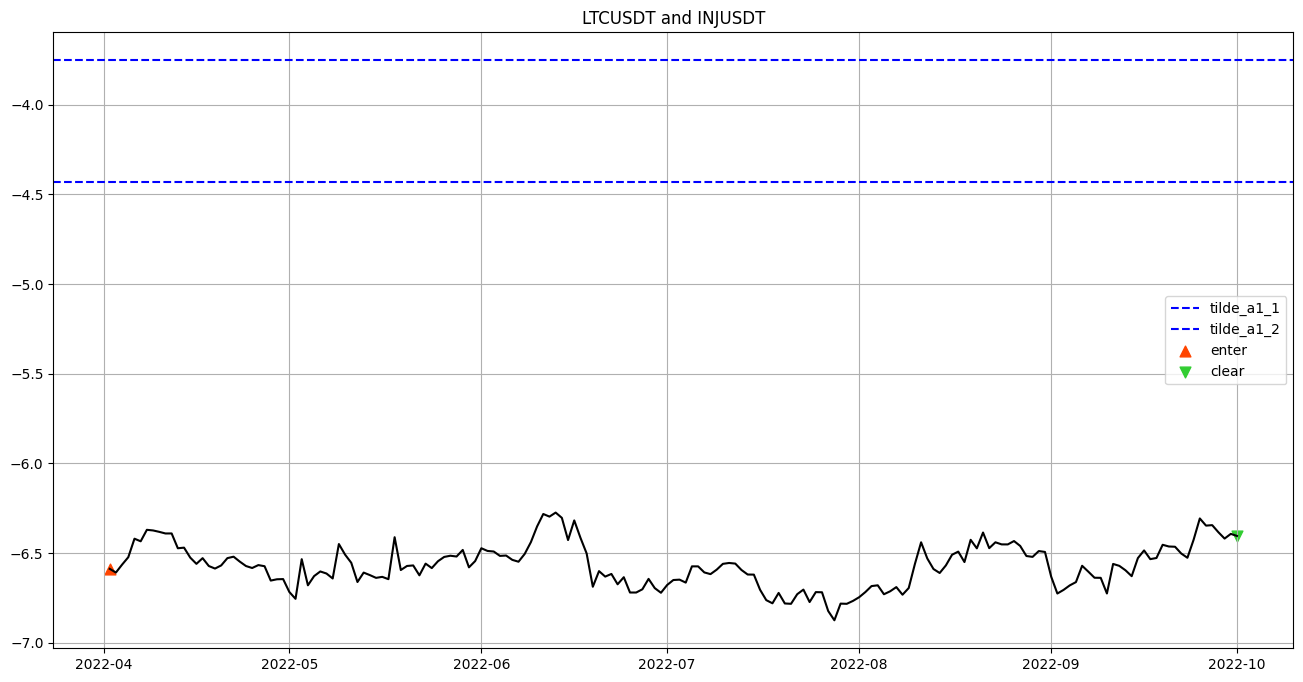

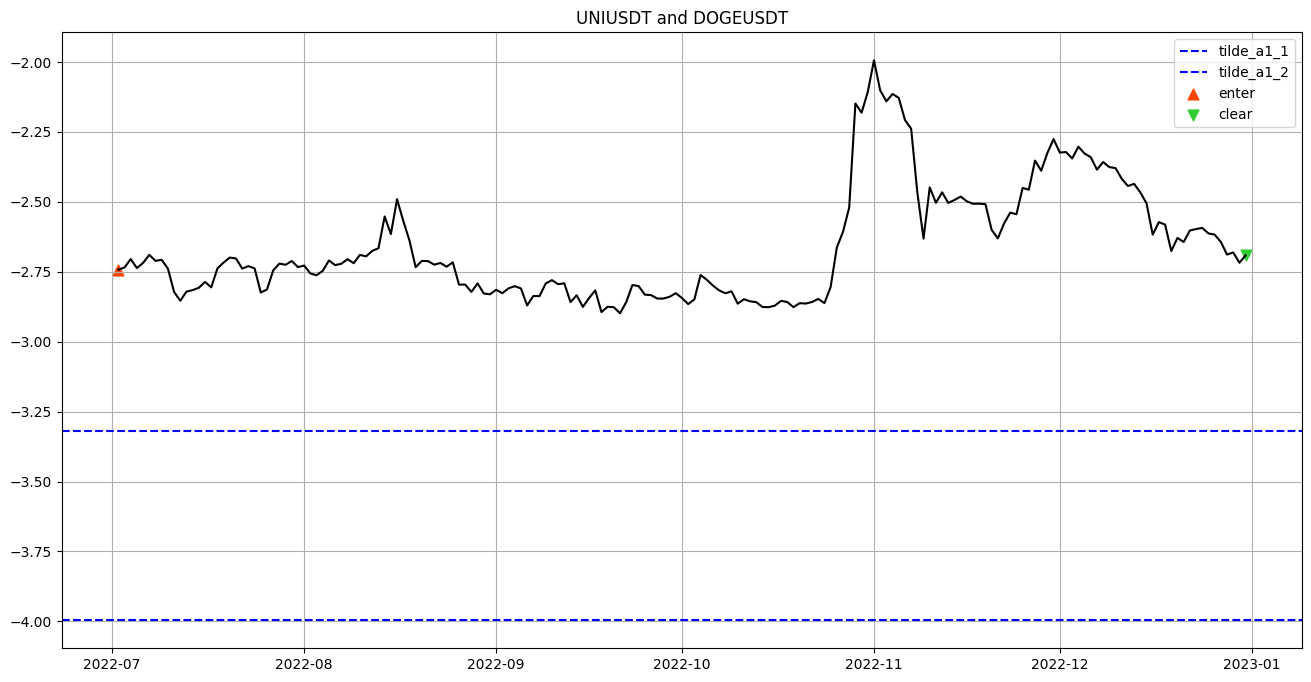

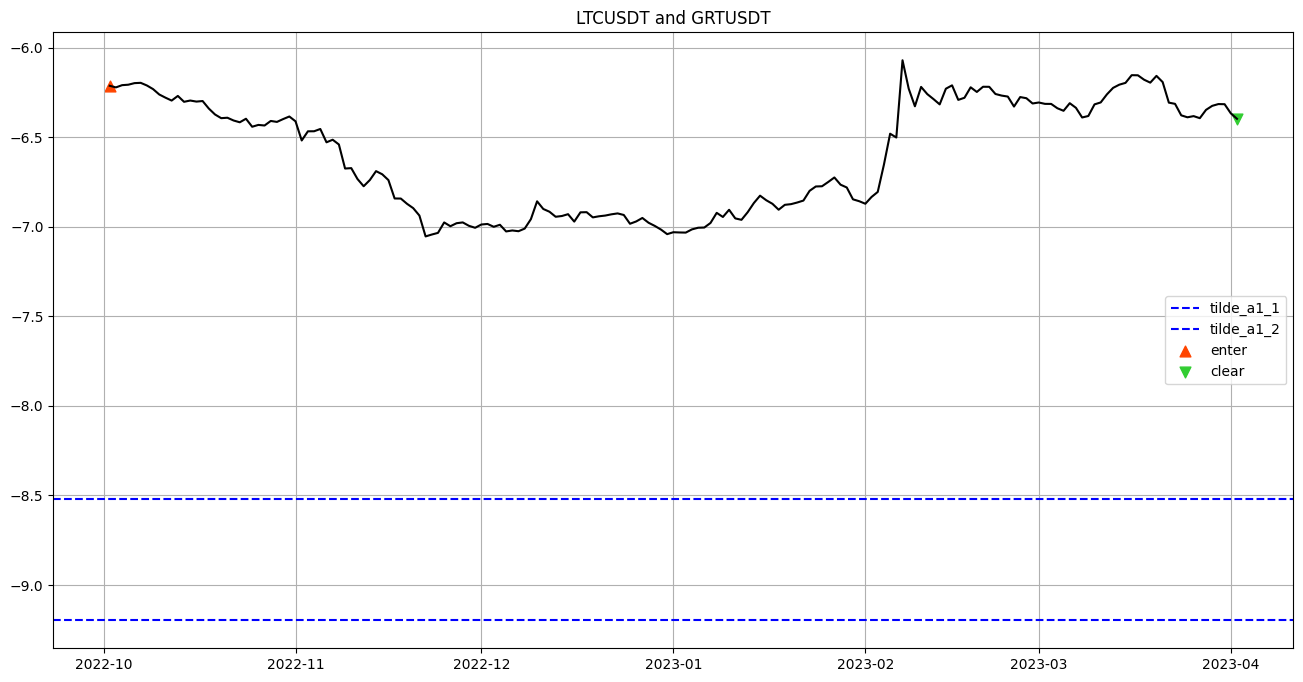

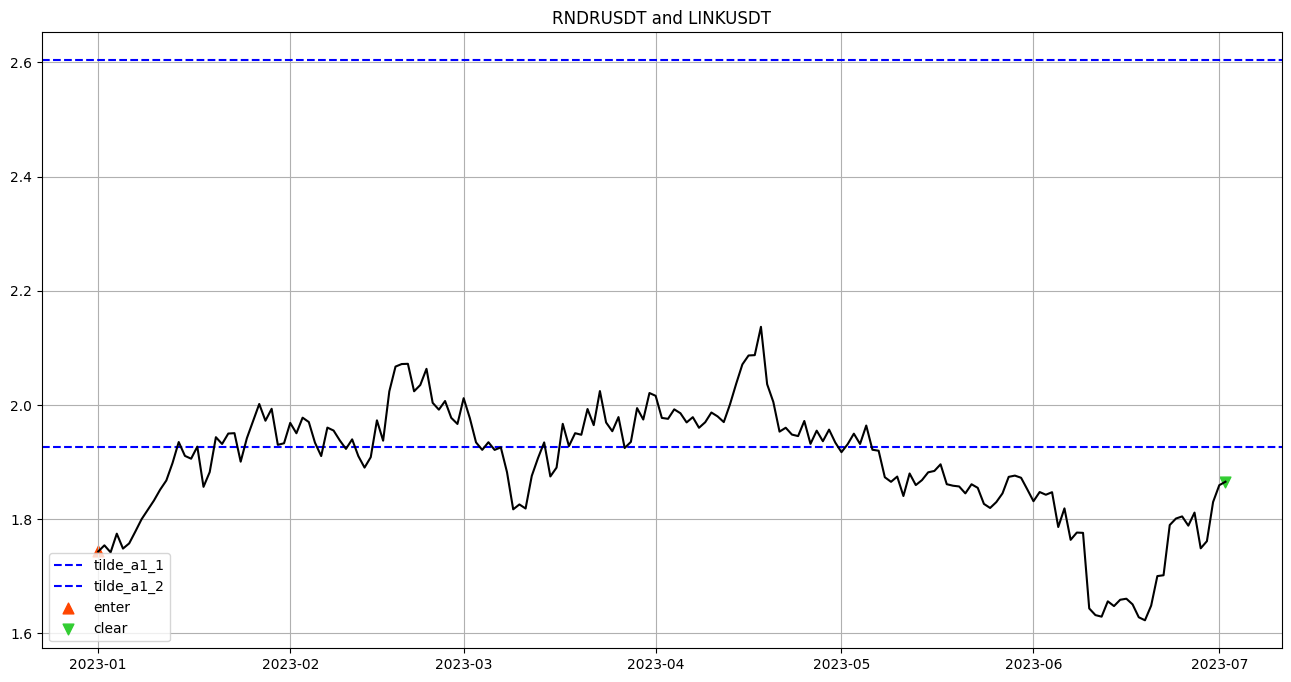

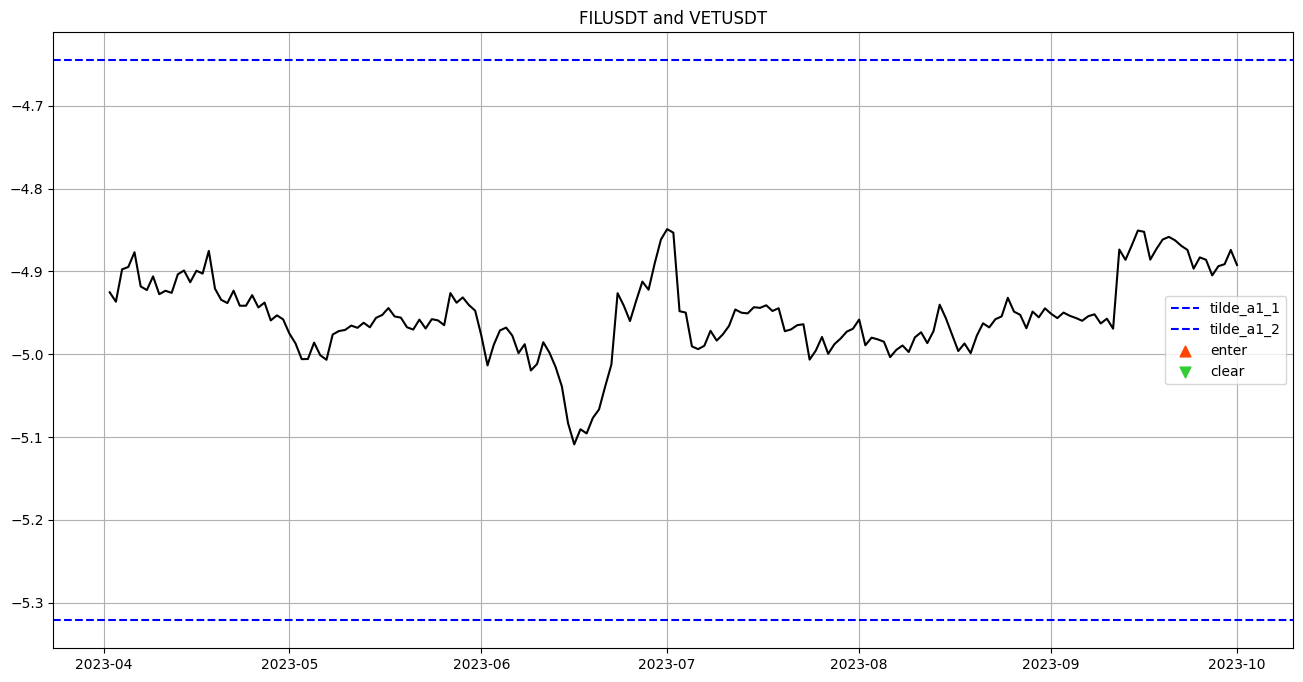

In [29]:
for x in range(intervalNum):
    plt.figure(figsize=(16, 8))
    
    name_P = selectedFinalName[x][0]
    name_Q = selectedFinalName[x][1]
    
    X = Xlist[(name_P, name_Q)]
    
    tilde_a2_1 = paramSecond[x][0]
    tilde_a2_2 = paramSecond[x][1]

    plt.axhline(y = tilde_a2_1, color = 'blue', linestyle = '--', label = 'tilde_a1_1')
    plt.axhline(y = tilde_a2_2, color = 'blue', linestyle = '--', label = 'tilde_a1_2')
    
    e = enter[x]
    c = clear[x]
    plt.scatter(X.iloc[e].index, X.iloc[e],c = 'orangered', label = 'enter', marker='^', s=60)
    plt.scatter(X.iloc[c].index, X.iloc[c],c = 'limegreen', label = 'clear', marker='v', s=60)

    plt.grid('True')
    plt.legend()

    plt.title(f"{name_Q} and {name_P}")
    plt.plot(X, label = 'spread', color = 'black')